In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
#from itertools import permutations
from collections import Counter
from math import ceil
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.outliers_influence import variance_inflation_factor 
#from statsmodels.tools.tools import add_constant
from scipy.stats import ks_2samp
from scipy.stats import rankdata
from scipy.special import softmax
from scipy.stats import zscore

import os
from sklearn.preprocessing import RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.preprocessing import power_transform

from stargazer.stargazer import Stargazer



## Utils

In [2]:
#years = [y for y in range(2000, 2022)]

In [3]:
# years

In [4]:
def get_variables(from_, to_, incl_rect=True):
    
    years = [y for y in range(from_, to_+1)]
    
    variables = [f"frq_{y}" for y in years]
    variables.extend([f"fpm_{y}" for y in years])
    variables.extend([f"gch_{y}:{y+1}" for y in years[:-1]])
    if incl_rect:
        variables.extend([f"rch_{y}:{y+1}" for y in years[:-1]])
    
    years = [str(y) for y in years]
    
    return variables, years

In [5]:
#variables

In [6]:
# redefine years
#years = [str(y) for y in years]

In [7]:
terms = [
'N1_kulturberikare',
'V1_berika',
'N1_berikare',
'N1_globalist',
'V1_kulturberika',
'N1_återvandring',
'V1_återvandra',
'A1_globalistisk',
'N1_förortsgäng',
]

In [8]:
def get_df(path, variables, terms, min_freq=10, drop_frq=True):
    df = pd.read_csv(Path(path), sep=";", index_col = 0)
    terms = [t for t in terms if t in df.index]
    #print(terms)
    df = df[variables]
    df = df.loc[terms]
    
    if min_freq != None:
        years = [col.split("_")[-1] for col in df.columns if col.startswith("frq_")]
        for dwe in df.index:
            for year in years:
                if df.loc[dwe][f"frq_{year}"] < min_freq: 
                    df.at[dwe, f"fpm_{year}"] = np.nan
                    
                    if year == max(years):
                        df.at[dwe, f"gch_{int(year)-1}:{year}"] = np.nan
                        df.at[dwe, f"rch_{int(year)-1}:{year}"] = np.nan
                    else:
                        df.at[dwe, f"gch_{year}:{int(year)+1}"] = np.nan
                        df.at[dwe, f"rch_{year}:{int(year)+1}"] = np.nan
    
    if drop_frq:
        df.drop([col for col in df.columns if col.startswith("frq_")], axis=1, inplace=True)

    return df

In [9]:
def get_iod(path, ref_path, variables, terms, min_freq=10):
    
    df = pd.read_csv(path, index_col=0)
    
    #print("Years in IOD data:", list(df.columns))
    
    ref = get_df(ref_path, variables, terms, min_freq = None, drop_frq=False)
    
    years = [col.split("_")[-1] for col in ref.columns if col.startswith("frq_")]
    
    #print("Years in LSC data:", years)
    
    if min_freq != None:
        for dwe in ref.index:
            for year in years:
                if ref.loc[dwe][f"frq_{year}"] < min_freq:
                    df.loc[df["DWE"] == dwe, year] = np.nan    
                    
    return df


In [10]:
def add_iod_dif(df, years):
    transitions = [(y, str(int(y)+1)) for y in years[:-1]]
    df = df.copy()
    for yi, yj in transitions:
#         df[f"{yi[2:]}:{yj[2:]}"] = abs(df[f"{yj}"] - df[f"{yi}"])
#         df[f"{yi}:{yj}"] = abs(df[f"{yj}"] - df[f"{yi}"])
        df[f"{yi}:{yj}"] = df[f"{yj}"] - df[f"{yi}"]

    return df

## A. FLASHBACK 

In [11]:
#years

### Main

In [12]:
variables, years = get_variables(2000, 2022)
# variables, years = get_variables(2000, 2021) # <-- Obs!

fb_sgns_lsc = get_df(
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted.csv", 
    variables, 
    terms,
    drop_frq = False
)
fb_kb_lsc   = get_df("/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-bert-sentence-bert-swedish-cased.csv", 
                  variables, 
                  terms)
fb_sts_lsc  = get_df("/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-bert-sts_fbmodel.csv", 
                  variables, 
                  terms)

In [13]:
fb_sgns_iod = get_iod(
    "/home/max/Results/replacements/results/fb_sgns_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted.csv", 
    variables, 
    terms
)
fb_sgns_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True)

fb_kb_iod = get_iod(
    "/home/max/Results/replacements/results/fb_kb_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-bert-sentence-bert-swedish-cased.csv", 
    variables, 
    terms
)

fb_sts_iod = get_iod(
    "/home/max/Results/replacements/results/fb_sts_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-bert-sentence-bert-swedish-cased.csv", 
    variables, 
    terms
)

### berT5

In [14]:
variables, years = get_variables(2000, 2022)
# variables, years = get_variables(2000, 2021) # <-- Obs!

fb_bert_lsc   = get_df("/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-bert-base-swedish-cased.csv", 
                  variables, 
                  terms)
fb_megatron_lsc  = get_df("/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-megatron-bert-large-swedish-cased-110k.csv", 
                  variables, 
                  terms)
fb_t5small_lsc   = get_df("/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-t5-small.csv", 
                  variables, 
                  terms)
fb_t53b_lsc  = get_df("/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-t5-3b.csv", 
                  variables, 
                  terms)
fb_mt5xl_lsc  = get_df("/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-mt5-xl.csv", 
                  variables, 
                  terms)

In [15]:
fb_bertCLS_iod = get_iod(
    "/home/max/Results/replacements/results/fb_bert-kb_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-bert-base-swedish-cased.csv", 
    variables, 
    terms
)

fb_bert_iod = get_iod(
    "/home/max/Results/replacements/results/fb_bert-kb-avg_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-bert-base-swedish-cased.csv", 
    variables, 
    terms
)

fb_megatron_iod = get_iod(
    "/home/max/Results/replacements/results/fb_megatron_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-megatron-bert-large-swedish-cased-110k.csv", 
    variables, 
    terms
)

fb_t5small_iod = get_iod(
    "/home/max/Results/replacements/results/fb_t5-small_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-t5-small.csv", 
    variables, 
    terms
)

fb_t53b_iod = get_iod(
    "/home/max/Results/replacements/results/fb_t5-3b_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-t5-3b.csv", 
    variables, 
    terms
)

fb_mt5xl_iod = get_iod(
    "/home/max/Results/replacements/results/fb_mt5-xl_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-mt5-xl.csv", 
    variables, 
    terms
)

### Different window sizes

In [16]:
WS=5
variables_noRCH, _ = get_variables(2000, 2022, incl_rect=False)
fb_sgns_lsc_w5 = get_df(f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}.csv", 
    variables_noRCH, terms, drop_frq = False)
fb_sgns_w5_iod = get_iod(f"/home/max/Results/replacments_w5-15_d100-200/results/fb_sgns-w{WS}_results.csv",
    f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}.csv", 
    variables_noRCH, terms)
fb_sgns_w5_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True) 

In [17]:
WS=10
variables_noRCH, _ = get_variables(2000, 2022, incl_rect=False)
fb_sgns_lsc_w10 = get_df(f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}.csv", 
    variables_noRCH, terms, drop_frq = False)
fb_sgns_w10_iod = get_iod(f"/home/max/Results/replacments_w5-15_d100-200/results/fb_sgns-w{WS}_results.csv",
    f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}.csv", 
    variables_noRCH, terms)
fb_sgns_w10_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True) 

In [18]:
WS=15
variables_noRCH, _ = get_variables(2000, 2022, incl_rect=False)
fb_sgns_lsc_w15 = get_df(f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}.csv", 
    variables_noRCH, terms, drop_frq = False)
fb_sgns_w15_iod = get_iod(f"/home/max/Results/replacments_w5-15_d100-200/results/fb_sgns-w{WS}_results.csv",
    f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}.csv", 
    variables_noRCH, terms)
fb_sgns_w15_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True) 

### 200 dimensions

In [19]:
WS=5
variables_noRCH, _ = get_variables(2000, 2022, incl_rect=False)
fb_sgns_lsc_w5_200 = get_df(f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}-200.csv", 
    variables_noRCH, terms, drop_frq = False)
fb_sgns_w5_200_iod = get_iod(f"/home/max/Results/replacments_w5-15_d100-200/results/fb_sgns-w{WS}-200_results.csv",
    f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}-200.csv", 
    variables_noRCH, terms)
fb_sgns_w5_200_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True) 

In [20]:
WS=10
variables_noRCH, _ = get_variables(2000, 2022, incl_rect=False)
fb_sgns_lsc_w10_200 = get_df(f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}-200.csv", 
    variables_noRCH, terms, drop_frq = False)
fb_sgns_w10_200_iod = get_iod(f"/home/max/Results/replacments_w5-15_d100-200/results/fb_sgns-w{WS}-200_results.csv",
    f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}-200.csv", 
    variables_noRCH, terms)
fb_sgns_w10_200_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True) 

In [21]:
WS=15
variables_noRCH, _ = get_variables(2000, 2022, incl_rect=False)
fb_sgns_lsc_w15_200 = get_df(f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}-200.csv", 
    variables_noRCH, terms, drop_frq = False)
fb_sgns_w15_200_iod = get_iod(f"/home/max/Results/replacments_w5-15_d100-200/results/fb_sgns-w{WS}-200_results.csv",
    f"/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w{WS}-200.csv", 
    variables_noRCH, terms)
fb_sgns_w15_200_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True) 

### ... with global initialization: NLPL

In [22]:
variables_noRCH, _ = get_variables(2000, 2022, incl_rect=False)
# LSC
fb_sgns_lsc_nlpl = get_df(
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w_glob_nlpl.csv", 
    variables_noRCH, 
    terms,
    drop_frq = False
)
# IOD
fb_sgns_iod_nlpl = get_iod(
    "/home/max/Results/rplc_w-global-nlpl/results/sgns-w-global-nlpl_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted-w_glob_nlpl.csv", 
    variables_noRCH, 
    terms
)
fb_sgns_iod_nlpl.rename(columns={"B-strategy": "B-Strategy"}, inplace=True) 

### ... re-run globalist

In [23]:
os.listdir("/home/max/Results/rplc_globalist_2nd_round/results")

['fl_globalist_kb_results.csv',
 'fb_globalist_sgns_results.csv',
 'fb_globalist_sts_results.csv',
 'fb_globalist_kb_results.csv',
 'fl_globalist_sgns_results.csv']

In [24]:
fb_sgns_G_iod = get_iod(
    "/home/max/Results/rplc_globalist_2nd_round/results/fb_globalist_sgns_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-radical3-restricted.csv", 
    variables, 
    terms
)
fb_sgns_G_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True) 

fb_kb_G_iod   = get_iod(
    "/home/max/Results/rplc_globalist_2nd_round/results/fb_globalist_kb_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-bert-sentence-bert-swedish-cased.csv", 
    variables, 
    terms
)

fb_sts_G_iod  = get_iod(
    "/home/max/Results/rplc_globalist_2nd_round/results/fb_globalist_sts_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fb_pol-yearly-bert-sentence-bert-swedish-cased.csv", 
    variables, 
    terms
)

### Add IOD difference

Consider using absolute values

In [25]:
fb_sgns_iod   = add_iod_dif(fb_sgns_iod, years)
fb_kb_iod     = add_iod_dif(fb_kb_iod, years)
fb_sts_iod    = add_iod_dif(fb_sts_iod, years)

fb_bert_iod     = add_iod_dif(fb_bert_iod, years)
fb_bertCLS_iod  = add_iod_dif(fb_bertCLS_iod, years)
fb_megatron_iod = add_iod_dif(fb_megatron_iod, years)
fb_t5small_iod  = add_iod_dif(fb_t5small_iod, years)
fb_t53b_iod     = add_iod_dif(fb_t53b_iod, years)
fb_mt5xl_iod    = add_iod_dif(fb_mt5xl_iod, years)

fb_sgns_G_iod = add_iod_dif(fb_sgns_G_iod, years)
fb_kb_G_iod   = add_iod_dif(fb_kb_G_iod, years)
fb_sts_G_iod  = add_iod_dif(fb_sts_G_iod, years)

fb_sgns_iod_nlpl = add_iod_dif(fb_sgns_iod_nlpl, years)

fb_sgns_w5_iod  = add_iod_dif(fb_sgns_w5_iod, years)
fb_sgns_w10_iod = add_iod_dif(fb_sgns_w10_iod, years)
fb_sgns_w15_iod = add_iod_dif(fb_sgns_w15_iod, years)

fb_sgns_w5_200_iod  = add_iod_dif(fb_sgns_w5_200_iod, years)
fb_sgns_w10_200_iod  = add_iod_dif(fb_sgns_w10_200_iod, years)
fb_sgns_w15_200_iod  = add_iod_dif(fb_sgns_w15_200_iod, years)



## B. FAMILJELIV

In [26]:
#fm_years

In [27]:
sorted(os.listdir("/home/max/Results/replacements/results/"))

['fb_bert-kb-avg_results.csv',
 'fb_bert-kb_results.csv',
 'fb_kb_results.csv',
 'fb_megatron_results.csv',
 'fb_mt5-xl_results.csv',
 'fb_sgns_results.csv',
 'fb_sts_results.csv',
 'fb_t5-3b_results.csv',
 'fb_t5-small_results.csv',
 'fm_bert-kb_results.csv',
 'fm_kb_results.csv',
 'fm_megatron_results.csv',
 'fm_sgns_results.csv',
 'fm_t5-3b_results.csv',
 'fm_t5-small_results.csv']

### Main

In [28]:
fm_variables, fm_years = get_variables(2003, 2022)
# fm_variables, fm_years = get_variables(2003, 2021) # <-- Obs!

fm_sgns_lsc = get_df("/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-radical3-restricted.csv", fm_variables, terms)
fm_kb_lsc   = get_df("/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-bert-sentence-bert-swedish-cased.csv", fm_variables, terms)

In [29]:
fm_sgns_iod = get_iod(
    "/home/max/Results/replacements/results/fm_sgns_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-radical3-restricted.csv", 
    fm_variables, 
    terms
)

fm_kb_iod   = get_iod(
    "/home/max/Results/replacements/results/fm_kb_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-bert-sentence-bert-swedish-cased.csv", 
    fm_variables, 
    terms
)

### berT5

In [30]:
# variables, years = get_variables(2000, 2022)
# variables, years = get_variables(2000, 2021) # <-- Obs!

fm_bert_lsc   = get_df("/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-bert-base-swedish-cased.csv", 
                  fm_variables, 
                  terms)
fm_megatron_lsc  = get_df("/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-megatron-bert-large-swedish-cased-110k.csv", 
                  fm_variables, 
                  terms)
fm_t5small_lsc   = get_df("/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-t5-small.csv", 
                  fm_variables, 
                  terms)
fm_t53b_lsc  = get_df("/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-t5-3b.csv", 
                  fm_variables, 
                  terms)

In [31]:
fm_bert_iod = get_iod(
    "/home/max/Results/replacements/results/fm_bert-kb_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-bert-base-swedish-cased.csv", 
    fm_variables, 
    terms
)

fm_megatron_iod = get_iod(
    "/home/max/Results/replacements/results/fm_megatron_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-megatron-bert-large-swedish-cased-110k.csv", 
    fm_variables, 
    terms
)

fm_t5small_iod = get_iod(
    "/home/max/Results/replacements/results/fm_t5-small_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-t5-small.csv", 
    fm_variables, 
    terms
)

fm_t53b_iod = get_iod(
    "/home/max/Results/replacements/results/fm_t5-3b_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-t5-3b.csv", 
    fm_variables, 
    terms
)

### Different window sizes

In [32]:
WS=5
variables_noRCH, _ = get_variables(2003, 2022, incl_rect=False)
fm_sgns_lsc_w5 = get_df(
    f"/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-radical3-restricted-w{WS}-100.csv", 
    variables_noRCH, terms, drop_frq = False)
fm_sgns_w5_iod = get_iod(
    f"/home/max/Results/replacments_w5-15_d100-200/results/fm_sgns-w{WS}-d100_results.csv",
    f"/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-radical3-restricted-w{WS}-100.csv", 
    variables_noRCH, terms)
fm_sgns_w5_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True) 

In [33]:
WS=10
variables_noRCH, _ = get_variables(2003, 2022, incl_rect=False)
fm_sgns_lsc_w10 = get_df(
    f"/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-radical3-restricted-w{WS}-100.csv", 
    variables_noRCH, terms, drop_frq = False)
fm_sgns_w10_iod = get_iod(
    f"/home/max/Results/replacments_w5-15_d100-200/results/fm_sgns-w{WS}-d100_results.csv",
    f"/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-radical3-restricted-w{WS}-100.csv", 
    variables_noRCH, terms)
fb_sgns_w10_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True) 

In [34]:
WS=15
variables_noRCH, _ = get_variables(2003, 2022, incl_rect=False)
fm_sgns_lsc_w15 = get_df(
    f"/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-radical3-restricted-w{WS}-100.csv", 
    variables_noRCH, terms, drop_frq = False)
fm_sgns_w15_iod = get_iod(
    f"/home/max/Results/replacments_w5-15_d100-200/results/fm_sgns-w{WS}-d100_results.csv",
    f"/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-radical3-restricted-w{WS}-100.csv", 
    variables_noRCH, terms)
fm_sgns_w15_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True) 

### 200 dimensions

In [35]:
WS=5
variables_noRCH, _ = get_variables(2003, 2022, incl_rect=False)
fm_sgns_lsc_w5_200 = get_df(
    f"/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-radical3-restricted-w{WS}-200.csv", 
    variables_noRCH, terms, drop_frq = False)
fm_sgns_w5_200_iod = get_iod(
    f"/home/max/Results/replacments_w5-15_d100-200/results/fm_sgns-w{WS}-d200_results.csv",
    f"/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-radical3-restricted-w{WS}-200.csv", 
    variables_noRCH, terms)
fm_sgns_w5_200_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True) 

In [36]:
WS=10
variables_noRCH, _ = get_variables(2003, 2022, incl_rect=False)
fm_sgns_lsc_w10_200 = get_df(
    f"/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-radical3-restricted-w{WS}-200.csv", 
    variables_noRCH, terms, drop_frq = False)
fm_sgns_w10_200_iod = get_iod(
    f"/home/max/Results/replacments_w5-15_d100-200/results/fm_sgns-w{WS}-d200_results.csv",
    f"/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-radical3-restricted-w{WS}-200.csv", 
    variables_noRCH, terms)
fm_sgns_w10_200_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True) 

In [37]:
WS=15
variables_noRCH, _ = get_variables(2003, 2022, incl_rect=False)
fm_sgns_lsc_w15_200 = get_df(
    f"/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-radical3-restricted-w{WS}-200.csv", 
    variables_noRCH, terms, drop_frq = False)
fm_sgns_w15_200_iod = get_iod(
    f"/home/max/Results/replacments_w5-15_d100-200/results/fm_sgns-w{WS}-d200_results.csv",
    f"/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-radical3-restricted-w{WS}-200.csv", 
    variables_noRCH, terms)
fm_sgns_w15_200_iod.rename(columns={"B-strategy": "B-Strategy"}, inplace=True) 

### ... re-run globalist

In [38]:
fm_sgns_G_iod = get_iod(
    "/home/max/Results/rplc_globalist_2nd_round/results/fl_globalist_sgns_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-radical3-restricted.csv", 
    fm_variables, 
    terms
)

fm_kb_G_iod     = get_iod(
    "/home/max/Results/rplc_globalist_2nd_round/results/fl_globalist_kb_results.csv",
    "/home/max/Documents/mlt/thesis/dw_results/fm_smh-yearly-bert-sentence-bert-swedish-cased.csv", 
    fm_variables, 
    terms
)

### Add IOD difference

In [39]:
fm_sgns_iod   = add_iod_dif(fm_sgns_iod, fm_years)
fm_kb_iod     = add_iod_dif(fm_kb_iod, fm_years)

fm_sgns_G_iod = add_iod_dif(fm_sgns_G_iod, fm_years)
fm_kb_G_iod   = add_iod_dif(fm_kb_G_iod, fm_years)

fm_bert_iod = add_iod_dif(fm_bert_iod, fm_years)
fm_megatron_iod = add_iod_dif(fm_megatron_iod, fm_years)
fm_t5small_iod = add_iod_dif(fm_t5small_iod, fm_years)
fm_t53b_iod = add_iod_dif(fm_t53b_iod, fm_years)

fm_sgns_w5_iod  = add_iod_dif(fm_sgns_w5_iod, fm_years)
fm_sgns_w10_iod = add_iod_dif(fm_sgns_w10_iod, fm_years)
fm_sgns_w15_iod = add_iod_dif(fm_sgns_w15_iod, fm_years)

fm_sgns_w5_200_iod  = add_iod_dif(fm_sgns_w5_200_iod, fm_years)
fm_sgns_w10_200_iod  = add_iod_dif(fm_sgns_w10_200_iod, fm_years)
fm_sgns_w15_200_iod  = add_iod_dif(fm_sgns_w15_200_iod, fm_years)

### Know your data

In [ ]:
sgns_iod

In [ ]:
sgns_iod[(sgns_iod["DWE"] == "V1_berika") & ((sgns_iod["Method"] == "cnt-ssc") | (sgns_iod["Method"] == "cnt-smx"))]

In [ ]:
set(sgns_iod["DWE"].values)

In [ ]:
fm_sgns_iod

In [ ]:
set(fm_sgns_lsc.index)

### Why does not min_freq work properly???

Helt obegripligt!!

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
columns = [col for col in sgns_iod.columns if ":" not in col]
mamma = sgns_iod.copy()
mamma = mamma[mamma["A-Strategy"]=="top3"]
mamma = mamma[mamma["B-Strategy"]=="lazy"]
mamma = mamma[mamma["Method"]=="I-cnt"]
mamma.drop(columns=["A-Strategy", "B-Strategy", "Method"], inplace=True)
mamma.set_index("DWE", inplace=True)
mamma = mamma[years].sort_index()
mamma.round(2)

In [ ]:
mu = sgns_lsc[[col for col in sgns_lsc if col.startswith("frq")]].sort_index()
mu.rename(columns={col:col.split("_")[-1] for col in mu.columns}).astype(int)

## Regression

In [ ]:
fb_sgns_iod

In [ ]:
fb_sgns_lsc.columns

In [ ]:
def data2data(
    iod_data, 
    lsc_data, 
    dwes, 
    AB_strat, 
    years, 
    methods, 
    baseline="first", 
    add_log_fpm=True, 
    add_freq_dif=True,
    LOG = np.log2
):
    
    df = iod_data.copy()
    
    df = df[df["DWE"].isin(dwes)]

    assert type(AB_strat) == dict
        
    for var, val in AB_strat.items():
        df = df[df[var]==val]
    
    df.drop(AB_strat.keys(), axis=1, inplace=True)
    
    transitions = [(year, str(int(year)+1)) for year in years[:-1]]
    
    lscs = ["fpm", "gch", "rch"]
    if add_freq_dif:
        lscs = lscs + ["fdf", "adf", "fpc", "apc"]
        lsc_data = lsc_data.copy()
        for yi, yj in transitions:
            lsc_data[f"fdf_{yi}:{yj}"] = lsc_data[f"fpm_{yj}"] - lsc_data[f"fpm_{yi}"] 
        for yi, yj in transitions:
            lsc_data[f"adf_{yi}:{yj}"] = abs(lsc_data[f"fpm_{yj}"] - lsc_data[f"fpm_{yi}"]) 
        for yi, yj in transitions:
            lsc_data[f"fpc_{yi}:{yj}"] = (lsc_data[f"fpm_{yj}"] - lsc_data[f"fpm_{yi}"]) / lsc_data[f"fpm_{yi}"]
        for yi, yj in transitions:
            lsc_data[f"apc_{yi}:{yj}"] = abs((lsc_data[f"fpm_{yj}"] - lsc_data[f"fpm_{yi}"]) / lsc_data[f"fpm_{yi}"])
        
    
#     transitions = [f"{year[2:]}:{str(int(year)+1)[2:]}" for year in years[:-1]]
    transitions = [f"{yi}:{yj}" for yi, yj in transitions]

    
    if baseline == "first":
        years = years[:-1]
    if baseline == "second":
        years = years[1:]
        
#     return [dw for lst in [[dw]*len(years) for dw in [df[df["Method"]=="I-cnt"]["DWE"]]] for dw in lst]

#     return df[df["Method"]=="I-cnt"][["DWE"]+years].set_index("DWE").sort_index()

    new_df = []
    dw_yrs = []
    for method in methods:
        s    = df[df["Method"]==method][["DWE"]+years].set_index("DWE").sort_index()
        idx  = [dw for lst in [[dw]*len(years) for dw in s.index] for dw in lst]
        yrs  = years*len(s.index)
        dw_yrs.append(pd.Series([f"{dw}_{y}" for dw, y in zip(idx, yrs)], name=method))
        new_df.append(pd.Series(s.to_numpy().flatten(), name=method))
        
    for method in methods: 
        s   = df[df["Method"]==method][["DWE"]+transitions].set_index("DWE").sort_index()
        idx = [dw for lst in [[dw]*len(transitions) for dw in s.index] for dw in lst]
        trs  = transitions*len(s.index)
        dw_yrs.append(pd.Series([f"{dw}_{y}" for dw, y in zip(idx, trs)], name=method+"_dif"))
        new_df.append(pd.Series(s.to_numpy().flatten(), name=method+"_dif"))
    
    for lsc_measure in lscs:
        if lsc_measure == "fpm":
            variables = [col for col in lsc_data.columns if col.startswith("fpm") and col.split("_")[-1] in years]
            s = lsc_data.loc[dwes][variables].sort_index()
            idx  = [dw for lst in [[dw]*len(years) for dw in s.index] for dw in lst]
            yrs  = years*len(s.index)
            dw_yrs.append(pd.Series([f"{dw}_{y}" for dw, y in zip(idx, yrs)], name=lsc_measure))
            new_df.append(pd.Series(s.to_numpy().flatten(), name=lsc_measure))
            if add_log_fpm:
                new_df.append(pd.Series(LOG(s.to_numpy().flatten()), name=lsc_measure+"_log"))
            
        else:
            variables = [col for col in lsc_data.columns if col.startswith(lsc_measure)]
            s = lsc_data.loc[dwes][variables].sort_index()
            idx = [dw for lst in [[dw]*len(transitions) for dw in s.index] for dw in lst]
            trs  = trs*len(s.index)
            dw_yrs.append(pd.Series([f"{dw}_{y}" for dw, y in zip(idx, trs)], name=lsc_measure))
            new_df.append(pd.Series(s.to_numpy().flatten(), name=lsc_measure))
    
    check = pd.concat(dw_yrs, axis=1)
    
    if False in (check[methods].eq(check["fpm"], axis=0)).all(axis=1):
        print("No match")
    
    if False in (check[[col for col in check.columns if col.endswith("dif")]].eq(check[["gch","rch"]], axis=0)).all(axis=1):
        print("No match")
        
    data = pd.concat(new_df+[check["fpm"].rename("DW-YR")], axis=1)
    
    return data


In [ ]:
def OLS(data, DEP, INDEP, transform_dep=False, dep_transformer=None, LOG=np.log2): 
    
    df = data[[DEP]+INDEP].copy()
    df = df.dropna(axis=0)
    
    X = df[INDEP]
    y = df[DEP]
    
    if transform_dep: 
        if dep_transformer == None:
            y = LOG(y)
        elif dep_transformer == "rank":
            y = rankdata(y)
        else:
            y = y.values.reshape(-1,1)
            if dep_transformer == "box-cox":
                transformer = PowerTransformer(method='box-cox')
                y = transformer.fit_transform(y)
                #y = power_transform(y, method='box-cox')
                print("Lambda = ", transformer.lambdas_[0])
            elif dep_transformer == "yeo-johnson":
                y = power_transform(y, method='yeo-johnson')
            else:
                transformer = dep_transformer
                y = transformer.fit_transform(y)

    X = sm.add_constant(X)

    model = sm.OLS(y, X, missing="drop").fit()

    return model

In [ ]:
def revise_data(data, indep, dep, iod_var, log_iod=False, LOG=np.log2):
    
    #indep = indep + [iod_var]
    #print(indep)
    data = data[indep+[dep]]
    data = data.dropna()
    data[iod_var] = abs(data[iod_var])
    if log_iod:
        data[iod_var] = LOG(data[iod_var])
    return data

In [ ]:
# https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python
# https://github.com/kennethleungty/Logistic-Regression-Assumptions/issues/2

def VIF(data, dep):
    exog_data_const = sm.add_constant(data[[c for c in data.columns if c != dep]])
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(exog_data_const.values, i) for i in range(exog_data_const.shape[1])]
    vif = vif.transpose()
    vif.columns = exog_data_const.columns
    return vif

In [ ]:
def test_normality_multi( # test assumptions
    names, # list
    iods, # list
    lscs, # list
    dep, 
    indep, 
    iod_var, 
    dwes, 
    abstrats, # list 
    years, 
    methods, 
    baseline, 
    log_transform,
    log_transform_iod = False,
    test_stat = "jarque_bera", 
    LOG=np.log2
):
    resids = []
    VIFs = []
    
    if iod_var not in indep:
        indep.append(iod_var)
    
    for iod, lsc, abstrat in zip(iods, lscs, abstrats):
    
        data = data2data(
            iod_data = iod, 
            lsc_data = lsc, 
            dwes     = dwes,
            AB_strat = abstrat, 
            years    = years,
            methods  = methods,
            baseline = baseline
            )
        
        data = revise_data(data, indep, dep, iod_var, log_iod=log_transform_iod, LOG=LOG)
        
        vif = VIF(data, dep)
        VIFs.append(vif)
#         return vif
        
        #indep = indep + [iod_var] 
        #data = data[indep + [dep]]
        #data = data.dropna()
        #data[iod_var] = abs(data[iod_var]) 
        
        #if log_transform_iod:
        #    data[iod_var] = np.log10(data[iod_var])

        res = OLS(data, dep, indep, transform_dep=log_transform, LOG=LOG)#, dep_transformer="box-cox" )
        resids.append(res.resid)
    
    dfs = []
    for r in resids:
        normality_res = pg.normality(r, method=test_stat)
#         return normality_res
        dfs.append(normality_res)
        
    df = pd.concat(dfs, axis = 0)
    df.index = names
    VIF_tab = pd.concat(VIFs)
    VIF_tab.index = names
    
    return df, VIF_tab
        

In [ ]:
def stargazer_multi(
    names, # list
    iods, # list
    lscs, # list
    dep, 
    indep, 
    iod_var, 
    dwes, 
    abstrats, # list 
    years, 
    methods, 
    baseline, 
    log_transform,
    log_transform_iod = False,
    #test_stat = "jarque_bera",
    LOG=np.log2,
    norm=False
):
    models = []
    
    if iod_var not in indep:
        indep.append(iod_var)
    
    for iod, lsc, abstrat in zip(iods, lscs, abstrats):
    
        data = data2data(
            iod_data = iod, 
            lsc_data = lsc, 
            dwes     = dwes,
            AB_strat = abstrat, 
            years    = years,
            methods  = methods,
            baseline = baseline,
            LOG=LOG
            )
        
        data = revise_data(data, indep, dep, iod_var)
        if log_transform:
            data[dep] = LOG(data[dep])
        if log_transform_iod:
            data[iod_var] = LOG(data[iod_var])        
        
        #indep = indep + [iod_var] 
        #data = data[indep + [dep]]
        #data = data.dropna()
        #data[iod_var] = abs(data[iod_var]) 
        
        #if log_transform_iod:
        #    data[iod_var] = np.log10(data[iod_var])
        
        if norm:
            for c in data.columns:
                data[c] = zscore(data[c])
            
        res = OLS(data, dep, indep)
        models.append(res)

#         else:
#             res = OLS(data, dep, indep, transform_dep=log_transform, LOG=LOG)#, dep_transformer="box-cox" )
#             models.append(res)
    
    ziggy = Stargazer(models)
    ziggy.custom_columns(names)#, [1, 1])
    ziggy.show_model_numbers(False)
    ziggy.covariate_order(sorted(indep)+["const"])
    ziggy.rename_covariates({'cnt-ssc_dif': '$\Delta ^{IOR}$', 'fpc':'$\Delta ^{FPM}$', 'fpm_log': 'FPM (log)' })
    ziggy.significance_levels([0.05, 0.01, 0.001])
    
    return ziggy
        

#### Formula-versions

In [ ]:
def test_normality_multi_FORMULA( # test assumptions
    names, # list
    iods, # list
    lscs, # list
    dep, 
    indep, 
    iod_var, 
    dwes, 
    abstrats, # list 
    years, 
    methods, 
    baseline, 
    log_transform,
    log_transform_iod = False,
    test_stat = "jarque_bera", 
    LOG=np.log2,
    interaction = None
):
    resids = []
    VIFs = []
    
    if iod_var not in indep:
        indep.append(iod_var)

    ######################################################################    
    f_renamer = {old: old.replace("-", "_") for old in indep + [dep]}
    
    formula = f"{f_renamer[dep]} ~ {' + '.join([f_renamer[v] for v in indep])}" #'Lottery ~ Literacy + Wealth + Region'
    if interaction != None:
        add_interactions = []
        for a, b in interaction:
            add_interactions.append(f"{f_renamer[a]}:{f_renamer[b]}")
        formula += f" + {' + '.join(add_interactions)}"
    #######################################################################
    
    for iod, lsc, abstrat in zip(iods, lscs, abstrats):
    
        data = data2data(
            iod_data = iod, 
            lsc_data = lsc, 
            dwes     = dwes,
            AB_strat = abstrat, 
            years    = years,
            methods  = methods,
            baseline = baseline
            )
        
        data = revise_data(data, indep, dep, iod_var, log_iod=log_transform_iod, LOG=LOG)
        
        ###############################################
        if log_transform:
            data[dep] = LOG(data[dep])
        data.rename(columns=f_renamer, inplace=True)
        ###############################################
        vif = VIF(data, dep)
        VIFs.append(vif)
        
        res = smf.ols(formula=formula, data=data).fit()
        #res = OLS(data, dep, indep, transform_dep=log_transform, LOG=LOG)#, dep_transformer="box-cox" )
        resids.append(res.resid)
    
    dfs = []
    for r in resids:
        normality_res = pg.normality(r, method=test_stat)
#         return normality_res
        dfs.append(normality_res)
        
    df = pd.concat(dfs, axis = 0)
    df.index = names
    VIF_tab = pd.concat(VIFs)
    VIF_tab.index = names
    
    return df, VIF_tab
        

In [ ]:
def stargazer_multi_FORMULA(
    names, # list
    iods, # list
    lscs, # list
    dep, 
    indep, 
    iod_var, 
    dwes, 
    abstrats, # list 
    years, 
    methods, 
    baseline, 
    log_transform,
    log_transform_iod = False,
    #test_stat = "jarque_bera",
    LOG=np.log2,
    norm=False,
    interaction = None, 
    ziggy_renamer = None
):
    models = []
    
    if iod_var not in indep:
        indep.append(iod_var)
        
    ######################################################################    
    f_renamer = {old: old.replace("-", "_") for old in indep + [dep]}
    
    formula = f"{f_renamer[dep]} ~ {' + '.join([f_renamer[v] for v in indep])}" #'Lottery ~ Literacy + Wealth + Region'
    if interaction != None:
        add_interactions = []
        for a, b in interaction:
            add_interactions.append(f"{f_renamer[a]}:{f_renamer[b]}")
        formula += f" + {' + '.join(add_interactions)}"
    #######################################################################        
    
    for iod, lsc, abstrat in zip(iods, lscs, abstrats):
    
        data = data2data(
            iod_data = iod, 
            lsc_data = lsc, 
            dwes     = dwes,
            AB_strat = abstrat, 
            years    = years,
            methods  = methods,
            baseline = baseline,
            LOG=LOG
            )
        
        data = revise_data(data, indep, dep, iod_var)
        if log_transform:
            data[dep] = LOG(data[dep])
        if log_transform_iod:
            data[iod_var] = LOG(data[iod_var])        
        
        #indep = indep + [iod_var] 
        #data = data[indep + [dep]]
        #data = data.dropna()
        #data[iod_var] = abs(data[iod_var]) 
        
        #if log_transform_iod:
        #    data[iod_var] = np.log10(data[iod_var])
        
        if norm:
            for c in data.columns:
                data[c] = zscore(data[c])
        
        ###############################
        data.rename(columns=f_renamer, inplace=True)
        res = smf.ols(formula=formula, data=data).fit()

        #res = OLS(data, dep, indep)
        models.append(res)

#         else:
#             res = OLS(data, dep, indep, transform_dep=log_transform, LOG=LOG)#, dep_transformer="box-cox" )
#             models.append(res)
    
    ziggy = Stargazer(models)
    ziggy.custom_columns(names)#, [1, 1])
    ziggy.show_model_numbers(False)
    ziggy.covariate_order(sorted([v for v in res.params.index if v != "Intercept"])+["Intercept"])
    ziggy.rename_covariates({
        'cnt_ssc_dif': '$\Delta ^{IOR}$', 
        'fpc':'$\Delta ^{FPM}$', 
        'fpm_log': 'FPM (log)',
        'fpm_log:cnt_ssc_dif': 'FPM (log) × $\Delta ^{IOR}$', 
        'fpm:cnt_ssc_dif': 'FPM × $\Delta ^{IOR}$'
    })
    ziggy.significance_levels([0.05, 0.01, 0.001])
    
    return ziggy
        

### Multi: Normality, VIF, and models

In [ ]:
ALL_FB_LSC = [
#fb_sgns_lsc,
fb_kb_lsc,
#fb_sts_lsc,
fb_bert_lsc,
# fb_bert_lsc, #  same for CLS version
#fb_megatron_lsc,
#fb_t5small_lsc,
# fb_t53b_lsc,
fb_mt5xl_lsc,
# fb_sgns_G_lsc,
# fb_kb_G_lsc,
# fb_sts_G_lsc,
#fb_sgns_lsc_nlpl,
fb_sgns_lsc_w5,
fb_sgns_lsc_w10,
fb_sgns_lsc_w15,
fb_sgns_lsc_w5_200,
fb_sgns_lsc_w10_200,
fb_sgns_lsc_w15_200    
]

In [ ]:
ALL_FB_IOD = [
#fb_sgns_iod,
fb_kb_iod,
#fb_sts_iod,
fb_bert_iod,
# fb_bertCLS_iod,
#fb_megatron_iod,
#fb_t5small_iod,
# fb_t53b_iod,
fb_mt5xl_iod,
# fb_sgns_G_iod,
# fb_kb_G_iod,
# fb_sts_G_iod,
#fb_sgns_iod_nlpl,
fb_sgns_w5_iod,
fb_sgns_w10_iod,
fb_sgns_w15_iod,
fb_sgns_w5_200_iod,
fb_sgns_w10_200_iod,
fb_sgns_w15_200_iod
]

In [ ]:
names = [
#"fb_sgns",
"SBERT", #"fb_kb",
#"fb_sts",
"BERT", #"fb_bert",
# "BERT-CLS",
#"fb_megatron",
#"T5-sml",#"fb_t5small",
# "T5-3b", #"fb_t53b",
"mT5-XL",
# "fb_sgns_G",
# "fb_kb_G",
# "fb_sts_G",
#"SGNS-nlpl",
"SGNS-w5",
"SGNS-w10",
"SGNS-w15",
"SGNS-w5-200",
"SGNS-w10-200",
"SGNS-w15-200"
]

In [ ]:
#ABSTRATs = [{"A-Strategy":"ms1", "B-Strategy":"min0.2"}] + [{"A-Strategy":"rn"}] * 6 + [{"A-Strategy":"ms1", "B-Strategy":"min0.2"}] * 7
#ABSTRATs = [{"A-Strategy":"rn"}] * 5 + [{"A-Strategy":"ms1", "B-Strategy":"min0.2"}] * 6
ABSTRATs = [{"A-Strategy":"rn"}] * 3 + [{"A-Strategy":"ms1", "B-Strategy":"min0.2"}] * 6

In [ ]:
DEP_TRANSFORM = True
IOD_TRANSFORM = False
IOD_VAR = "cnt-ssc_dif"
INDEP = [
    IOD_VAR,
    "fpc", 
#     "fpm"
    "fpm_log"
]
LOG = np.log2

In [ ]:
table, vif = test_normality_multi(
    names = names, # list
    iods = ALL_FB_IOD, # list
    lscs = ALL_FB_LSC, # list
    dep = "gch", 
    indep = INDEP, 
    iod_var = IOD_VAR, 
    dwes = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'], 
    abstrats = ABSTRATs, # list 
    years = years, 
    methods = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"], 
    baseline = "first", 
    log_transform = DEP_TRANSFORM,
    log_transform_iod=IOD_TRANSFORM,
#     test_stat = "shapiro" # "jarque_bera" (default),
    LOG = LOG
)
table.round(3)

In [ ]:
vif

In [ ]:
table, vif = test_normality_multi_FORMULA(
    names = names, # list
    iods = ALL_FB_IOD, # list
    lscs = ALL_FB_LSC, # list
    dep = "gch", 
    indep = INDEP, 
    iod_var = IOD_VAR, 
    dwes = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'], 
    abstrats = ABSTRATs, # list 
    years = years, 
    methods = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"], 
    baseline = "first", 
    log_transform = DEP_TRANSFORM,
    log_transform_iod=IOD_TRANSFORM,
#     test_stat = "shapiro" # "jarque_bera" (default),
    LOG = LOG, 
#     interaction = [("fpm_log", IOD_VAR)]
    interaction = [("fpm_log", IOD_VAR)]
)
table.round(3)

In [ ]:
#table = table.drop(["fb_sgns", "fb_megatron", "fb_sts"])
sum(table["normal"]) / table.shape[0]

In [ ]:
print(table.to_latex(float_format="{:0.3f}".format))

* For residuals to be normal: Dependent variable must be log_transformed
* For SGNS models, fpm should be log transformed for normal residuals
* For LLMs, fpm should not be log transformed for normal residulas
* Log transformation of iod_var + log tansform of dependent variable solves the normality issue, but lower R2

In [ ]:
all_stars = stargazer_multi(
    names = names, # list
    iods = ALL_FB_IOD, # list
    lscs = ALL_FB_LSC, # list
    dep = "gch", 
    indep = INDEP, 
    iod_var = IOD_VAR, 
    dwes = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'], 
    abstrats = ABSTRATs, # list 
    years = years, 
    methods = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"], 
    baseline = "first", 
    log_transform = DEP_TRANSFORM,
    log_transform_iod=IOD_TRANSFORM,
#     test_stat = "shapiro" # "jarque_bera" (default),
    LOG=LOG,
    norm = True
); all_stars

In [ ]:
all_stars = stargazer_multi_FORMULA(
    names = names, # list
    iods = ALL_FB_IOD, # list
    lscs = ALL_FB_LSC, # list
    dep = "gch", 
    indep = INDEP, 
    iod_var = IOD_VAR, 
    dwes = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'], 
    abstrats = ABSTRATs, # list 
    years = years, 
    methods = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"], 
    baseline = "first", 
    log_transform = DEP_TRANSFORM,
    log_transform_iod=IOD_TRANSFORM,
#     test_stat = "shapiro" # "jarque_bera" (default),
    LOG=LOG,
    norm = True,
    interaction = [("fpm_log", IOD_VAR)]
); all_stars

In [ ]:
print(all_stars.render_latex())

In [ ]:
data

### Reverese?

In [ ]:
indep = ["fpc", "fpm_log"]
lsc_var = "gch"
dep = "cnt-ssc_dif"

models = []
resids = []

for iod, lsc, abstrat in zip(ALL_FB_IOD, ALL_FB_LSC, ABSTRATs):

    data = data2data(
        iod_data = iod, 
        lsc_data = lsc, 
        dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
        AB_strat = abstrat, 
        years    = years,
        methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
        baseline = "first",
        LOG=np.log2
        )

#     data = revise_data(data, indep, dep, iod_var, log_iod=log_transform_iod, LOG=LOG)

    data = data[indep + [lsc_var] + [dep]]
    data = data.dropna()
    data[dep] = abs(data[dep])
    data[dep] = np.log2(data[dep])
    data[lsc_var] = np.log2(data[lsc_var])
    
    for c in data.columns:
        data[c] = zscore(data[c])    

    res = OLS(data, dep, indep + [lsc_var])#, transform_dep=log_transform)#, LOG=LOG)#, dep_transformer="box-cox" )
    models.append(res)
    resids.append(res.resid)

dfs = []
for r in resids:
    normality_res = pg.normality(r, method="jarque_bera")
#         return normality_res
    dfs.append(normality_res)   
df = pd.concat(dfs, axis = 0)
df.index = names    
    
ziggy = Stargazer(models)
ziggy.custom_columns(names)#, [1, 1])
ziggy.show_model_numbers(False)
ziggy.covariate_order(sorted(indep + [lsc_var])+["const"])
# ziggy.rename_covariates({'cnt-ssc_dif': 'Dif. IOD Ratio', 'fpc':'Dif. FPM (\%)', 'fpm_log': 'FPM (lg)' })
ziggy.significance_levels([0.05, 0.01, 0.001])

ziggy


In [ ]:
df

## Visualization, part 1

In [40]:
def get_dfs(iod_data_frames, criteria, dwes):
    dfs = []
    for D, criterion, dwe in zip(iod_data_frames, criteria, dwes):
        df = D.copy()
        df = df[df["DWE"] == dwe]
        for col, val in criterion.items():
            df = df[df[col] == val]
        dfs.append(df)
    return dfs

In [41]:
def organize_df(df, dwe, meas, yrs, inverse, normalize):
    
    dfs = []
    for measure in meas:
        X = df[df["Method"]==measure][yrs].values.flatten()
        if inverse != None:
            if inverse == measure:
                X = 1 - X
        if normalize:
            X = zscore(X, nan_policy="omit")
#             return X
        dfs.append(pd.DataFrame(X, columns=["Value"]))
     
    data = pd.concat(dfs, axis=0)
    data["DWE"]    = [dwe] * len(meas) * len(yrs) 
    data["Method"] = [m for measure in meas for m in [measure] * len(yrs)]
    data["Year"]   = [int(y) for y in yrs * len(meas)]
    
    return data


In [84]:
def annotate(data, **kws):
    r, p = pearsonr(data["Value"], data["Year"])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p), transform=ax.transAxes)

In [232]:
def reg_trend(
    iod_data_frames,
    dwes, 
    criteria, 
    years, 
    #meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    meas = ["I-cnt", "O-cnt", "cnt-ssc"],
    truncate = True,
    n_cols = 2,
    inverse=None,
    return_time_series = False,
    add_r = False,
    normalize = False, 
    smooth = False
):
    
    dfs = get_dfs(iod_data_frames, criteria, dwes)
    data = pd.concat([organize_df(df, dwe, meas, yrs, inverse, normalize) for df, dwe, yrs in zip(dfs, dwes, years)])
         
    if truncate:
        data = data[data["Value"].notna()]

    g = sns.lmplot(data=data, x="Year", y="Value", hue="Method", col="DWE", col_wrap=n_cols, lowess=smooth)
    # https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html
    # https://www.statisticshowto.com/lowess-smoothing/
    # https://ostwalprasad.github.io/machine-learning/Polynomial-Regression-using-statsmodel.html

    if add_r:
        color_order=["blue", "tab:orange", "green"][:len(meas)]
        for ax, dwe in zip(g.axes.flatten(), dwes):
            ax.tick_params(axis='x', rotation=45)

            this_df = data[data["DWE"]==dwe]
            for i, (method, color) in enumerate(zip(meas, color_order)):
                y = this_df[this_df["Method"]==method]["Value"]
                x = [v for v in range(len(y))]
                r, p = pearsonr(x, y)
                ax.text(0.2, 0.95-i/12, f'{method}: r={r:.2f}, p={p:.3f}', fontdict=dict(color=color, fontsize=12), transform=ax.transAxes) #add text

    plt.show()    

/home/max/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout(*args, **kwargs)


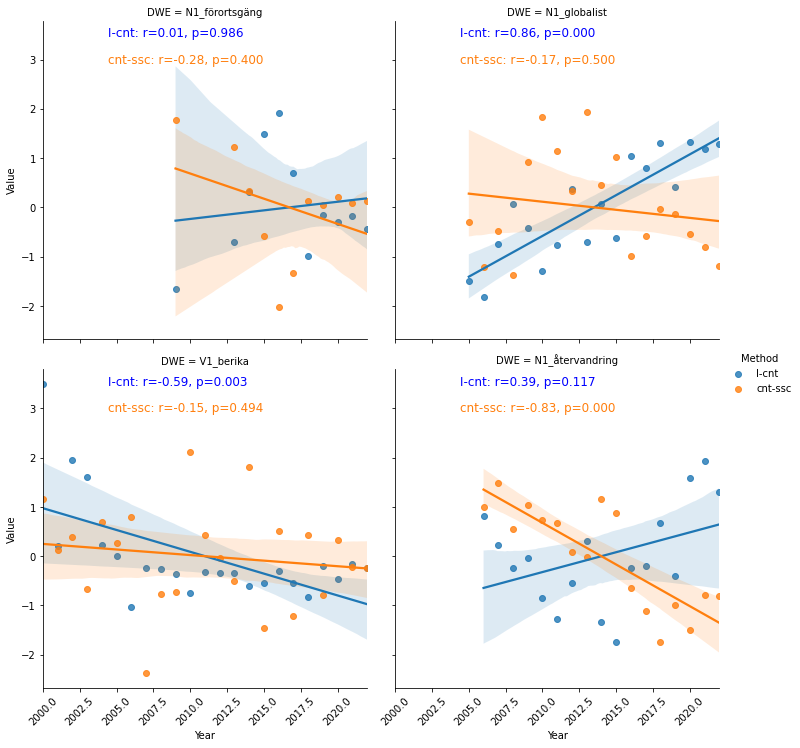

In [237]:
DWES = ["N1_förortsgäng", "N1_globalist", "V1_berika", "N1_återvandring"]
reg_trend(
    iod_data_frames = [fb_sgns_w15_200_iod]*4,
    dwes = DWES, 
    criteria = [{"A-Strategy":"ms1", "B-Strategy": "min0.2"}]*4, 
    years = [years]*4,
    meas=["I-cnt", "cnt-ssc"],
    truncate = True,
    inverse = "cnt-ssc",
    return_time_series=True,
    add_r = True,
    normalize = True,
#     smooth=True
)

/home/max/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout(*args, **kwargs)


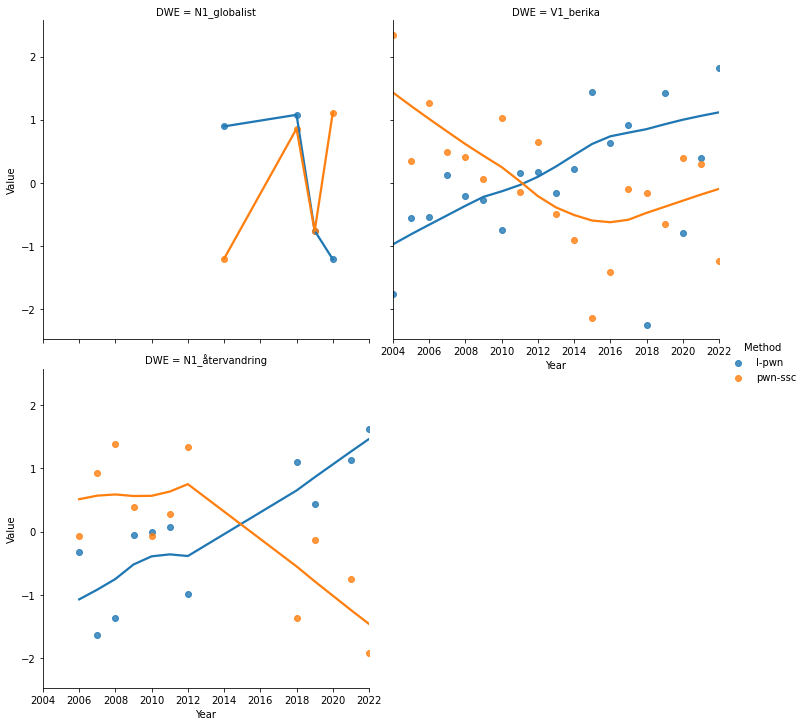

In [239]:
DWES = ["N1_förortsgäng", "N1_globalist", "V1_berika", "N1_återvandring"]
reg_trend(
    iod_data_frames = [fb_bert_iod]*4,
    dwes = DWES, 
    criteria = [{"A-Strategy":"rn"}]*4, 
    years = [years]*4,
    meas=["I-pwn", "pwn-ssc"],
    truncate = True,
    inverse = "pwn-ssc",
    return_time_series=True,
#     add_r = True,
    normalize = True,
    smooth=True
)

## Visualization, part 2

In [173]:
def viz(
    iod_data, 
    dwe, 
    criterion, 
    years, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True,
    #inverse = None
):
    
    df = iod_data.copy()
    df = df[df["DWE"] == dwe]
    
    for col, val in criterion.items():
        df = df[df[col] == val]
        
    #if inverse != None:
    #    df[inverse] = 1 - df[inverse]
    
    fig, ax = plt.subplots(figsize=(12,8))
    
    for m, c, l in meas:
        X = df[(df["DWE"] == dwe) & (df["Method"] == m)][years]
        if truncate:
            x, y = zip(*[(x, y) for x, y in zip(X.columns, X.values.flatten()) if not pd.isna(x) and not pd.isna(y)])
        else: 
            x = X.columns
            y = X.values.flatten()
            
        ax.plot(x, y, label=m, c=c, linestyle=l)
    ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncols=2)

    
    plt.show()
    
    

In [174]:
def viz_multi(
    title,
    iod_data_frames,
    names,
    dwes, 
    criteria, 
    years, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True,
    ncols = 2,
    inverse=None,
    return_time_series = False,
    normalize = True
):
    
    dfs = []
    for D, criterion, dwe in zip(iod_data_frames, criteria, dwes):
        df = D.copy()
        df = df[df["DWE"] == dwe]
        for col, val in criterion.items():
            df = df[df[col] == val]
        dfs.append(df)

    NROWS  = ceil(len(dfs) / ncols)
    NCOLS  = ncols
    WIDTH  = 12 * NCOLS
    HEIGTH = NROWS * 6 
    
    if return_time_series:
        time_series = []
    
    fig, axs = plt.subplots(NROWS, NCOLS, figsize=(WIDTH,HEIGTH))

    for df, ax, yrs, name in zip(dfs, axs.flatten(), years, names):
        if return_time_series:
            dwe_ts = []
        for m, c, l in meas:
            X = df[df["Method"] == m][yrs]
    
            if inverse != None:
                if inverse == m:
                    X = 1 - X
            
            if truncate:
                x, y = zip(*[(x, y) for x, y in zip(X.columns, X.values.flatten()) if not pd.isna(x) and not pd.isna(y)])
            else: 
                x = [int(c) for c in X.columns]
                y = X.values.flatten()
            
            if normalize:
                y = zscore(y)
            
            ax.plot(x, y, label=m, c=c, linestyle=l, linewidth=5)
            ax.set_title(name, fontsize=15)
            ax.set_xticks(range(len(x)))
            ax.set_xticklabels(x, rotation=35)#, ha='right')
            ax.legend()
            
            if return_time_series:
                dwe_ts.append(y)
        
        if return_time_series:
            time_series.append(dwe_ts)
    
    fig.suptitle(title, fontsize=25)
    plt.show()
    
    if return_time_series:
        return time_series    

### Raw Figures

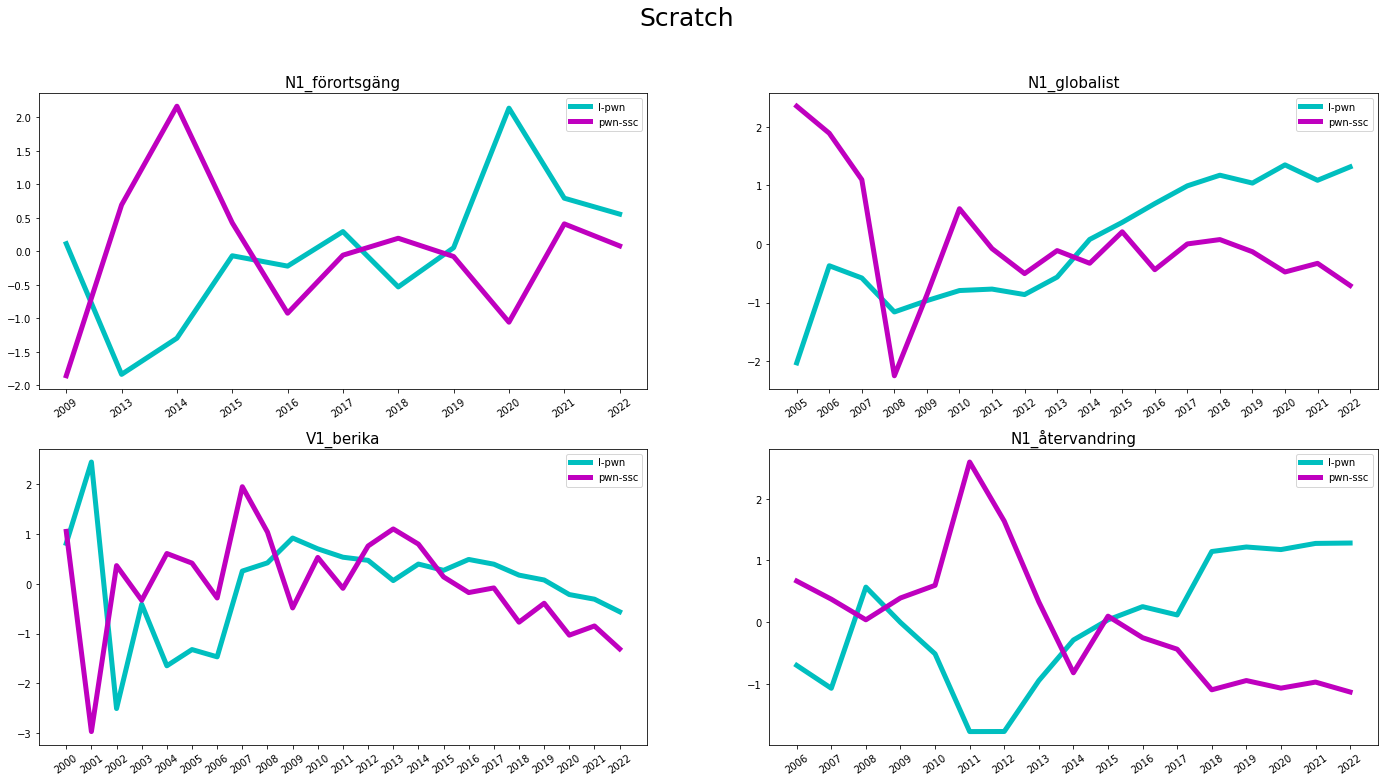

In [177]:
DWES = ["N1_förortsgäng", "N1_globalist", "V1_berika", "N1_återvandring"]
ts_data = viz_multi(
    title = "Scratch",
    #iod_data_frames = [fb_sgns_w5_200_iod]*4, 
    iod_data_frames = [fb_bert_iod]*4,
    names = DWES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"rn"}]*4, 
    #criteria = [{"A-Strategy":"ms1", "B-Strategy": "top3"}]*4,
    years = [years]*4,
    #meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    meas = [("I-pwn", "c", '-'), ("pwn-ssc", "m", '-')],
    truncate = True,
    inverse = "pwn-ssc",
    return_time_series=True,
    normalize = True
)

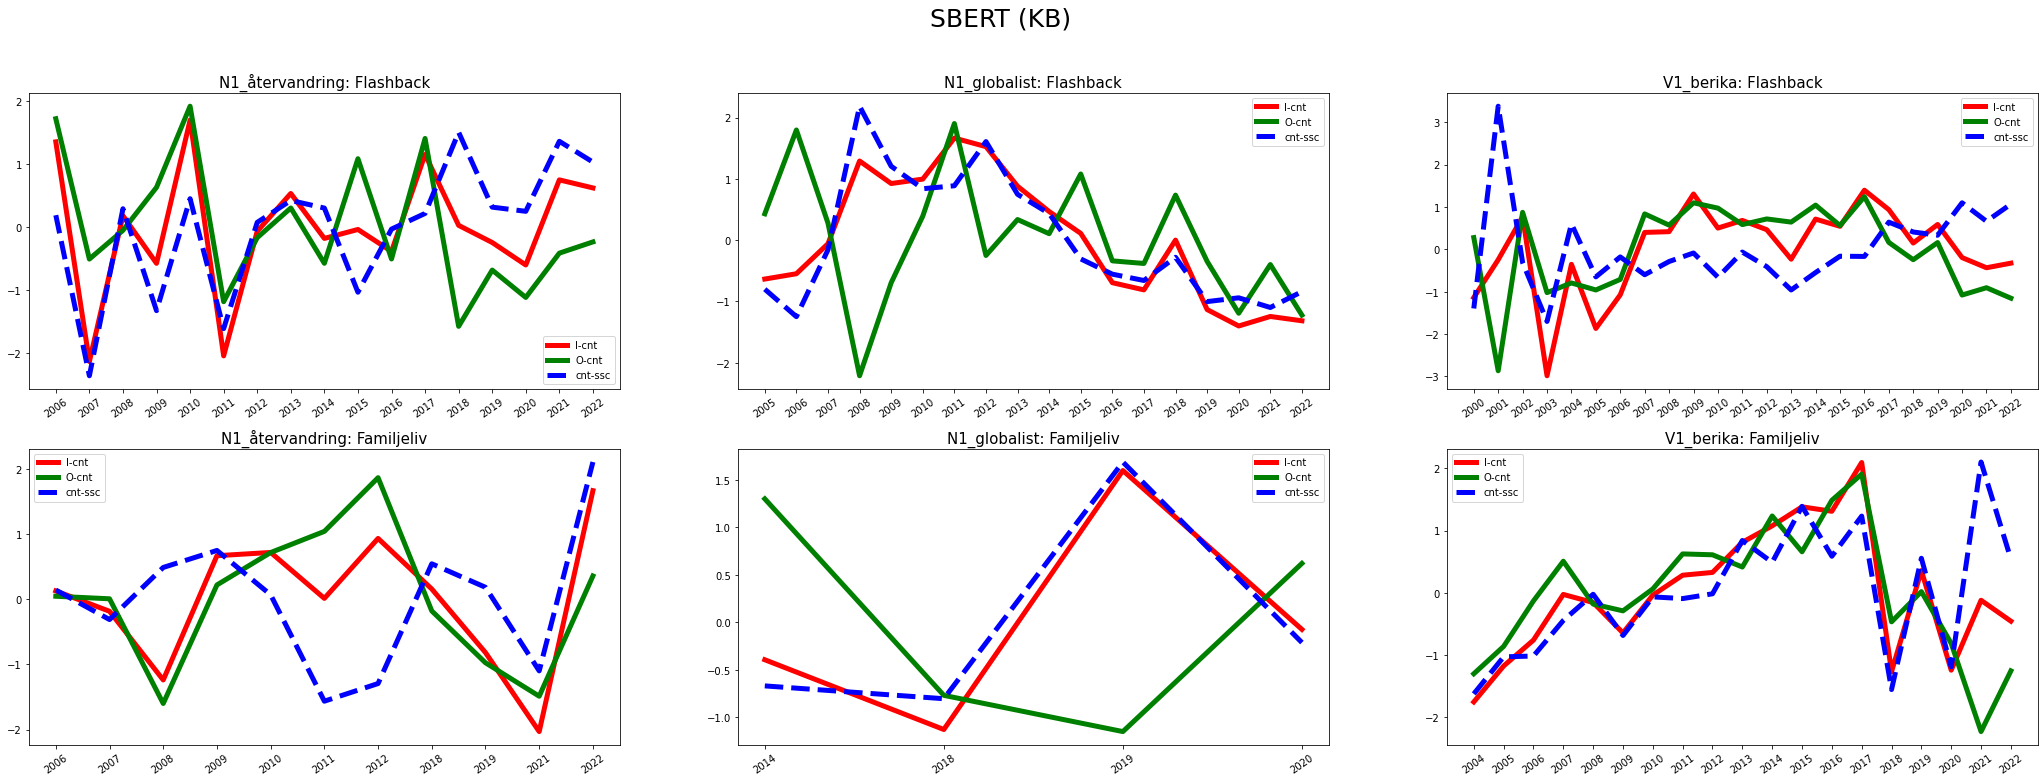

In [201]:
DWES = ["N1_återvandring","N1_globalist","V1_berika"]*2

NAMES = [f"{corpus}: {term}" for corpus, term in zip(DWES,["Flashback"]*3 + ["Familjeliv"]*3)]
#print(NAMES)

viz_multi(
    title = "SBERT (KB)",
    iod_data_frames = [fb_kb_iod]*3 + [fm_kb_iod]*3, 
    names = NAMES,
    dwes = DWES, 
    criteria = [{"A-Strategy":"rn"}]*6,  
    years = [years]*3 + [fm_years]*3, 
    meas = [("I-cnt", "r", '-'), ("O-cnt", "g", '-'), ("cnt-ssc", "b", '--')], 
    truncate = True,
    ncols = 3
)

## Ingroupness in FB and  FL

In [ ]:
fm_sgns_lsc.index

In [179]:
def t(iodA, yA, iodB, yB, dwes, criterion, method, collapse = False, ks=False, drop_from_results=["alternative","BF10", "power"]):
    
    dfA = iodA.copy()
    dfB = iodB.copy()
    
    criterion["Method"] = method
    
    for var, val in criterion.items():
        dfA = dfA[dfA[var]==val]
        dfB = dfB[dfB[var]==val]
    
    dfA.set_index("DWE", inplace=True)
    dfB.set_index("DWE", inplace=True)
    
    dfA = dfA.loc[dwes]
    dfB = dfB.loc[dwes]
    
    dfA = dfA[yA]
    dfB = dfB[yB]
    
    if collapse:
        A = dfA.values.flatten()
        B = dfB.values.flatten()
        if ks:
            return ks_2samp(A,B)
        results = pg.ttest(A,B)
        for exclude in drop_from_results:
            results.drop(exclude, axis=1, inplace=True)
            
        results["M_A"] = np.nanmean(A) 
        results["M_B"] = np.nanmean(B)
        results["N_A"] = len([a for a in A if not pd.isna(a)])
        results["N_B"] = len([b for b in B if not pd.isna(b)])
        return results
    else:
        results = []
        for dwe in dwes:
            A = dfA.loc[dwe].values.flatten()
            B = dfB.loc[dwe].values.flatten()
            result = pg.ttest(A,B)
            for exclude in drop_from_results:
                result.drop(exclude, axis=1, inplace=True)
            
            result["Term"] = dwe
            result["M_A"] = np.nanmean(A)
            result["sd_A"] = np.nanstd(A)
            result["N_A"] = len([a for a in A if not pd.isna(a)])
            result["M_B"] = np.nanmean(B)
            result["sd_B"] = np.nanstd(B)            
            result["N_B"] = len([b for b in B if not pd.isna(b)])
            results.append(result)
        results = pd.concat(results)
        results.set_index("Term", inplace=True)
        return results.round(3)
            
    

### SGNS

In [186]:
results = t(
    fb_sgns_w15_200_iod, 
    years, 
    fm_sgns_w15_200_iod, 
    fm_years, 
    fm_sgns_lsc.index, 
    {"A-Strategy":"ms1", "B-Strategy": "top3"},
    "cnt-ssc",
    collapse=False,
    #ks=True
)
#print(results.to_latex(float_format="{:.3f}".format))
results

,T,dof,p-val,CI95%,cohen-d,M_A,sd_A,N_A,M_B,sd_B,N_B
Term,,,,,,,,,,,
N1_kulturberikare,2.264,14.621,0.039,"[0.0, 0.08]",0.864,0.568,0.050,22,0.525,0.041,8
V1_berika,5.892,31.045,0.000,"[0.04, 0.07]",1.891,0.524,0.024,23,0.469,0.034,19
N1_globalist,-4.441,7.065,0.003,"[-0.14, -0.04]",2.404,0.518,0.034,18,0.609,0.042,6
V1_kulturberika,2.305,6.817,0.056,"[-0.0, 0.12]",1.116,0.591,0.050,18,0.535,0.043,5
N1_återvandring,8.997,17.435,0.000,"[0.09, 0.15]",3.692,0.548,0.029,17,0.425,0.037,11
V1_återvandra,2.872,4.633,0.038,"[0.0, 0.09]",1.565,0.450,0.030,17,0.402,0.026,4


In [182]:
results = t(
    fb_sgns_G_iod, 
    years, 
    fm_sgns_G_iod, 
    fm_years, 
    ["N1_globalist"], 
    {"A-Strategy":"ms1", "B-Strategy": "top3"},
    "cnt-smx",
    collapse=False,
    #ks=True
)
#print(results.to_latex(float_format="{:.3f}".format))
results

,T,dof,p-val,CI95%,cohen-d,M_A,sd_A,N_A,M_B,sd_B,N_B
Term,,,,,,,,,,,
N1_globalist,-5.433,6.836,0.001,"[-0.06, -0.02]",3.024,0.475,0.013,18,0.519,0.017,6


For every combination, GLOBALIST is more ingroup in familjeliv! 

### LLMs

In [ ]:
set(kb_iod["A-Strategy"])

In [197]:
results = t(
    fb_bert_iod, 
    years, 
    fm_bert_iod, 
    fm_years, 
    fm_sgns_lsc.index, 
    {"A-Strategy":"rn"},
    "I-cnt",
    collapse=False,
    #ks=True
)
#print(results.to_latex(float_format="{:.3f}".format))
results

,T,dof,p-val,CI95%,cohen-d,M_A,sd_A,N_A,M_B,sd_B,N_B
Term,,,,,,,,,,,
N1_kulturberikare,2.270,7.589,0.055,"[-0.0, 0.02]",1.414,0.717,0.005,22,0.705,0.013,8
V1_berika,5.420,33.707,0.000,"[0.02, 0.05]",1.720,0.673,0.018,23,0.637,0.023,19
N1_globalist,-1.537,5.535,0.179,"[-0.02, 0.0]",0.716,0.746,0.011,18,0.753,0.007,4
V1_kulturberika,2.607,4.251,0.056,"[-0.0, 0.05]",2.233,0.718,0.007,18,0.691,0.020,5
N1_återvandring,4.974,13.404,0.000,"[0.03, 0.07]",2.197,0.712,0.015,17,0.662,0.029,11
V1_återvandra,4.476,2.429,0.032,"[0.01, 0.1]",3.423,0.679,0.014,17,0.627,0.016,3


## Correlation

In [218]:
def compare(iod_data, term, criterion, method=pearsonr, years = years, add_mean=False):
    
    used = years + list(criterion.keys()) + ["DWE"] + [f"{year}:{int(year)+1}" for year in years[:-1]]
    remains = [col for col in iod_data.columns if col not in used]
    #print(remains)

    df = iod_data.copy()
    df = df[df["DWE"] == term]
    
    if type(criterion) == dict:
        criterion = criterion.items()
    for var, val in criterion:
        df = df[df[var]==val]
    
    df = df[years]
    
    labels = ["-".join(iod_data.loc[i][remains].to_list()) for i in df.index]
    
    df["labels"] = labels
    df = df.set_index("labels")
    
    correlations = df.transpose().corr().round(3)
    
    if add_mean:
        correlations["Mean"] = correlations.mean(axis=1)
    
    return correlations
        

In [221]:
compare(iod_data=fb_sgns_w15_200_iod, term="V1_berika", criterion={"A-Strategy":"ms1", "B-Strategy": "top3"}, years=years)

labels,I-cnt,O-cnt,cnt-ssc,cnt-smx,I-pwn,O-pwn,pwn-ssc,pwn-smx
labels,,,,,,,,
I-cnt,1.000,0.973,-0.014,0.231,0.976,0.966,0.009,0.016
O-cnt,0.973,1.000,-0.236,0.000,0.955,0.988,-0.199,-0.189
cnt-ssc,-0.014,-0.236,1.000,0.938,-0.025,-0.196,0.901,0.818
cnt-smx,0.231,0.000,0.938,1.000,0.201,0.018,0.880,0.865
I-pwn,0.976,0.955,-0.025,0.201,1.000,0.978,0.064,0.073
O-pwn,0.966,0.988,-0.196,0.018,0.978,1.000,-0.138,-0.138
pwn-ssc,0.009,-0.199,0.901,0.880,0.064,-0.138,1.000,0.958
pwn-smx,0.016,-0.189,0.818,0.865,0.073,-0.138,0.958,1.000


In [ ]:
# x =  fm_sgns_iod.drop("2022", axis=1)
# compare(iod_data=x, term="V1_berika", criterion={"A-Strategy":"ms1", "B-Strategy": "top3"}, years=fm_years)

## Correlation of *I* and *O*

Ingroup and outgroup are to a large extent correlated. For the SGNS models this is kind of expected given the semantic space the embeddings are trained in. For the SBERT-KB models this is more surprising. 

### SGNS - Flashback

In [228]:
correlations = []
for term in fm_sgns_lsc.index:
    r = compare(iod_data=fb_sgns_w15_200_iod, term=term, criterion={"A-Strategy":"top3", "B-Strategy": "lazy"}, years=years)
    score = r.loc["I-cnt"]["O-cnt"]
    correlations.append(score)
df1 = pd.DataFrame(correlations, index = fm_sgns_lsc.index, columns = ["r-sgns-fb"])
df1

,r-sgns-fb
N1_kulturberikare,0.899
V1_berika,0.972
N1_globalist,0.700
V1_kulturberika,0.635
N1_återvandring,-0.646
V1_återvandra,0.188


### SGNS - Familjeliv

In [ ]:
x = fm_sgns_iod
correlations = []

for term in fm_sgns_lsc.index:
    r = compare(iod_data=x, term=term, criterion={"A-Strategy":"ms1", "B-Strategy": "top3"}, years=fm_years)
    score = r.loc["I-cnt"]["O-cnt"]
    correlations.append(score)
df2 = pd.DataFrame(correlations, index = fm_sgns_lsc.index, columns = ["r-sgns-fl"])
df2

### SBERT - Flashback

In [ ]:
correlations = []
for term in fm_sgns_lsc.index:
    r = compare(iod_data=fb_kb_iod, term=term, criterion={"A-Strategy":"rn"}, years=years)
    score = r.loc["I-cnt"]["O-cnt"]
    correlations.append(score)
df3 = pd.DataFrame(correlations, index = fm_sgns_lsc.index, columns = ["r-sbert-fb"])
df3

In [ ]:
correlations = []
for term in fm_sgns_lsc.index:
    r = compare(iod_data=kb_iod, term=term, criterion={"A-Strategy":"top3"}, years=years)
    score = r.loc["I-cnt"]["O-cnt"]
    correlations.append(score)
df3 = pd.DataFrame(correlations, index = fm_sgns_lsc.index, columns = ["r-sbert-fb"])
df3

STS:

In [ ]:
correlations = []
for term in fm_sgns_lsc.index:
    r = compare(iod_data=fb_sts_iod, term=term, criterion={"A-Strategy":"rn"}, years=years)
    score = r.loc["I-cnt"]["O-cnt"]
    correlations.append(score)
df3 = pd.DataFrame(correlations, index = fm_sgns_lsc.index, columns = ["r-sbert-fb"])
df3

### berT5 - Flashback

In [225]:
correlations = []
for term in fm_sgns_lsc.index:
    r = compare(iod_data=fb_bert_iod, term=term, criterion={"A-Strategy":"rn"}, years=years)
    score = r.loc["I-cnt"]["O-cnt"]
    correlations.append(score)
df_bert = pd.DataFrame(correlations, index = fm_sgns_lsc.index, columns = ["r-sbert-fb"])
df_bert

,r-sbert-fb
N1_kulturberikare,0.986
V1_berika,0.998
N1_globalist,0.983
V1_kulturberika,0.982
N1_återvandring,0.999
V1_återvandra,0.984


### SBERT - Familjeliv

In [ ]:
#x = fm_kb_iod.drop("2022", axis=1)
correlations = []

for term in fm_sgns_lsc.index:
    r = compare(iod_data=fm_kb_iod, term=term, criterion={"A-Strategy":"rn"}, years=fm_years)
    score = r.loc["I-cnt"]["O-cnt"]
    correlations.append(score)
df4 = pd.DataFrame(correlations, index = fm_sgns_lsc.index, columns = ["r-sbert-fl"])
df4

In [ ]:
print(pd.concat([df1, df2, df3, df4], axis=1).to_latex(float_format="{:.3f}".format))

# Appendix

## Appendix: Individual regression models

### SGNS

In [ ]:
sgns

In [ ]:
# iod_var = "cnt-ssc_dif"
iod_var = "cnt-ssc_dif"
indep = [
    iod_var, 
    "fpc", #'fdf','adf', 'fpc', 'apc'
    #"fpm_rnk",
    "fpm_log",
#     "fpm"
]
dep="gch"
LOG_IOD = False
LOG_DEP = False

In [ ]:
DWE      = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng']
ABSTRAT  = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}
YEARS    = years
METHODS  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"]
BASELINE = "first"

##### W5, dim200

In [ ]:
data = data2data(
    iod_data = fb_sgns_w5_200_iod, 
    lsc_data = fb_sgns_lsc_w5_200, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

data = revise_data(data, indep, dep, iod_var, log_iod=LOG_IOD)
#data = data[indep+[dep]]
#data = data.dropna()
#data[iod_var] = abs(data[iod_var])
#data[iod_var] = np.log10(data[iod_var])

res_sgns_w5_200 = OLS(data, dep, indep, transform_dep=LOG_DEP)#, dep_transformer="box-cox" )
res_sgns_w5_200.summary()

In [ ]:
# data2data(
#     iod_data = fb_sgns_w5_200_iod, 
#     lsc_data = fb_sgns_lsc_w5_200, 
#     dwes     = DWE,
#     AB_strat = ABSTRAT, 
#     years    = YEARS,
#     methods  = METHODS,
#     baseline = BASELINE
# ).columns

In [ ]:
sns.heatmap(data[indep].corr(), annot=True)

In [ ]:
sns.histplot(data['fpm'])

##### W10, dim200

In [ ]:
data = data2data(
    iod_data = fb_sgns_w10_200_iod, 
    lsc_data = fb_sgns_lsc_w10_200, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

data = data[indep+[dep]]
data = data.dropna()
data[iod_var] = abs(data[iod_var]) 

res_sgns_w10_200 = OLS(data, "gch", indep, transform_dep=LOG_DEP)#, dep_transformer="box-cox" )
res_sgns_w10_200.summary()

##### W15, dim200

In [ ]:
data = data2data(
    iod_data = fb_sgns_w15_200_iod, 
    lsc_data = fb_sgns_lsc_w15_200, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

data = data[indep+[dep]]
data = data.dropna()
data[iod_var] = abs(data[iod_var]) 

res_sgns_w15_200  = OLS(data, "gch", indep, transform_dep=LOG_DEP)#, dep_transformer="box-cox" )
res_sgns_w15_200.summary()

In [ ]:
plt.scatter(zscore(data[iod_var]), zscore(data[dep]))
plt.show()
plt.scatter(data[iod_var], data[dep])
plt.show()

In [ ]:
gch, iod = zip(*sorted(zip(data["gch"], data["cnt-ssc_dif"])))
plt.plot(range(len(gch)), zscore(gch))
plt.plot(range(len(iod)), zscore(iod))
plt.show()

##### NLPL-init vectors

In [ ]:
data = data2data(
    iod_data = fb_sgns_iod_nlpl, 
    lsc_data = fb_sgns_lsc_nlpl, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

data = data[indep+[dep]]
data = data.dropna()
data[iod_var] = abs(data[iod_var]) 

res_sgns_nlpl = OLS(data, "gch", indep, transform_dep=LOG_DEP)#, dep_transformer="box-cox" )
res_sgns_nlpl.summary()

##### Original models

In [ ]:
data = data2data(
    iod_data = fb_sgns_iod, 
    lsc_data = fb_sgns_lsc, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

data = data[indep+[dep]]
data = data.dropna()
data[iod_var] = abs(data[iod_var]) 

res_sgns_orig = OLS(data, "gch", indep, transform_dep=LOG_DEP)#, dep_transformer="box-cox" )
res_sgns_orig.summary()

##### W5, dim100

In [ ]:
data = data2data(
    iod_data = fb_sgns_w5_iod, 
    lsc_data = fb_sgns_lsc_w5, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

data = data[indep+[dep]]
data = data.dropna()
data[iod_var] = abs(data[iod_var]) 

res_sgns_w5_100 = OLS(data, "gch", indep, transform_dep=LOG_DEP)#, dep_transformer="box-cox" )
res_sgns_w5_100.summary()

##### W10, dim100

In [ ]:
data = data2data(
    iod_data = fb_sgns_w10_iod, 
    lsc_data = fb_sgns_lsc_w10, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

data = data[indep+[dep]]
data = data.dropna()
data[iod_var] = abs(data[iod_var]) 

res_sgns_w10_100 = OLS(data, "gch", indep, transform_dep=LOG_DEP)#, dep_transformer="box-cox" )
res_sgns_w10_100.summary()

##### W15, dim100

In [ ]:
data = data2data(
    iod_data = fb_sgns_w15_iod, 
    lsc_data = fb_sgns_lsc_w15, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

data = data[indep+[dep]]
data = data.dropna()
data[iod_var] = abs(data[iod_var]) 

res_sgns_w15_100 = OLS(data, "gch", indep, transform_dep=LOG_DEP)#, dep_transformer="box-cox" )
res_sgns_w15_100.summary()

#### Comparison

In [ ]:
dfs = []

df_w5 = data2data(
    iod_data = fb_sgns_w5_iod, 
    lsc_data = fb_sgns_lsc_w5, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(df_w5[dep].rename("w5-100"))

df_w5_200 = data2data(
    iod_data = fb_sgns_w5_200_iod, 
    lsc_data = fb_sgns_lsc_w5_200, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(df_w5_200[dep].rename("w5-200"))

df_w10= data2data(
    iod_data = fb_sgns_w10_iod, 
    lsc_data = fb_sgns_lsc_w10, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(df_w10[dep].rename("w10-100"))

df_w10_200 = data2data(
    iod_data = fb_sgns_w10_200_iod, 
    lsc_data = fb_sgns_lsc_w10_200, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(df_w10_200[dep].rename("w10_200"))

df_w15= data2data(
    iod_data = fb_sgns_w15_iod, 
    lsc_data = fb_sgns_lsc_w15, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(df_w15[dep].rename("w15-100"))

df_w15_200 = data2data(
    iod_data = fb_sgns_w15_200_iod, 
    lsc_data = fb_sgns_lsc_w15_200, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(df_w15_200[dep].rename("w15_200"))

df_nlpl= data2data(
    iod_data = fb_sgns_iod_nlpl, 
    lsc_data = fb_sgns_lsc_nlpl, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(df_nlpl[dep].rename("nlpl"))

df_orig= data2data(
    iod_data = fb_sgns_iod, 
    lsc_data = fb_sgns_lsc, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(df_orig[dep].rename("orig"))

plt.figure(figsize=(8,8))
sns.heatmap(pd.concat(dfs, axis=1).corr(), annot=True)
plt.show()

In [ ]:
dfs = []
V = "cnt-ssc_dif"
df_w5 = data2data(
    iod_data = fb_sgns_w5_iod, 
    lsc_data = fb_sgns_lsc_w5, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(abs(df_w5[V]).rename("w5-100"))

df_w10= data2data(
    iod_data = fb_sgns_w10_iod, 
    lsc_data = fb_sgns_lsc_w10, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(abs(df_w10[V]).rename("w10-100"))

df_w15= data2data(
    iod_data = fb_sgns_w15_iod, 
    lsc_data = fb_sgns_lsc_w15, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(abs(df_w15[V]).rename("w15-100"))

df_w5_200 = data2data(
    iod_data = fb_sgns_w5_200_iod, 
    lsc_data = fb_sgns_lsc_w5_200, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(abs(df_w5_200[V]).rename("w5-200"))

df_w10_200= data2data(
    iod_data = fb_sgns_w10_200_iod, 
    lsc_data = fb_sgns_lsc_w10, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(abs(df_w10_200[V]).rename("w10-200"))

df_w15_200= data2data(
    iod_data = fb_sgns_w15_200_iod, 
    lsc_data = fb_sgns_lsc_w15_200, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(abs(df_w15_200[V]).rename("w15-200"))

df_nlpl= data2data(
    iod_data = fb_sgns_iod_nlpl, 
    lsc_data = fb_sgns_lsc_nlpl, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(abs(df_nlpl[V]).rename("nlpl"))

df_orig= data2data(
    iod_data = fb_sgns_iod, 
    lsc_data = fb_sgns_lsc, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
)
dfs.append(abs(df_orig[V]).rename("orig"))

plt.figure(figsize=(8,8))
sns.heatmap(pd.concat(dfs, axis=1).corr(), annot=True)
plt.show()

### SBERT

In [ ]:
#https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html

In [ ]:
DWE      = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng']
ABSTRAT  = {"A-Strategy":"rn"}
YEARS    = years
METHODS  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"]
BASELINE = "first"

In [ ]:
indep = [
    #"adf",
    "fpc",
    #"fpm_rnk",
       "fpm_log",
#     "fpm"
]
iod_var = "cnt-ssc_dif"
indep = indep + [iod_var]
dep="gch"
LOG_DEP = False

In [ ]:
data = data2data(
    iod_data = fb_kb_iod, 
    lsc_data = fb_kb_lsc, 
#    dwes     = sgns_lsc.index, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

data = data[indep+[dep]]
data = data.dropna()
data[iod_var] = abs(data[iod_var])

# data[iod_var] = np.log10(data[iod_var])

indep = [v for v in data.columns if v != dep]

res_sbert = OLS(data, dep, indep, transform_dep=LOG_DEP)#True, dep_transformer="box-cox") # dep_transformer="box-cox"
res_sbert.summary()
# res

In [ ]:
plt.plot(data[iod_var])
plt.plot(data[dep])

In [ ]:
gch, iod = zip(*sorted(zip(data[dep], data[iod_var])))
plt.plot(range(len(gch)), zscore(gch))
plt.plot(range(len(iod)), zscore(iod))

plt.show()

In [ ]:
# plt.scatter(zscore(data[iod_var]), zscore(data[dep]))
# plt.show()
plt.scatter(data[dep], data[iod_var], color="black")
# plt.xlabel(dep)
# plt.ylabel(iod_var)
plt.xlabel("$\Delta _{t_i, t_j}$", fontsize=14) # gch
plt.ylabel("$\Delta _{t_i, t_j} ^{IOR}$", fontsize=14)
plt.show()

In [ ]:
sns.histplot(res_sbert.resid)

In [ ]:
sm.qqplot(res_sbert.resid, line = "q")
plt.show()

In [ ]:
res_sbert

### mT5-XL

In [ ]:
#https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html

In [ ]:
DWE      = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng']
ABSTRAT  = {"A-Strategy":"rn"}
YEARS    = years
METHODS  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"]
BASELINE = "first"

In [ ]:
indep = [
    #"adf",
    "fpc",
    #"fpm_rnk",
       "fpm_log",
#     "fpm"
]
iod_var = "cnt-ssc_dif"
indep = indep + [iod_var]
dep="gch"
LOG_DEP = False

In [ ]:
data = data2data(
    iod_data = fb_mt5xl_iod, 
    lsc_data = fb_mt5xl_lsc, 
#    dwes     = sgns_lsc.index, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

data = data[indep+[dep]]
data = data.dropna()
data[iod_var] = abs(data[iod_var])

# data[iod_var] = np.log10(data[iod_var])

indep = [v for v in data.columns if v != dep]

res_mt5xl = OLS(data, dep, indep, transform_dep=LOG_DEP)#True, dep_transformer="box-cox") # dep_transformer="box-cox"
res_mt5xl.summary()
# res

In [ ]:
plt.plot(data[iod_var])
plt.plot(data[dep])

In [ ]:
gch, iod = zip(*sorted(zip(data[dep], data[iod_var])))
plt.plot(range(len(gch)), zscore(gch))
plt.plot(range(len(iod)), zscore(iod))

plt.show()

In [ ]:
# plt.scatter(zscore(data[iod_var]), zscore(data[dep]))
# plt.show()
plt.scatter(data[dep], data[iod_var], color="black")
# plt.xlabel(dep)
# plt.ylabel(iod_var)
plt.xlabel("$\Delta _{t_i, t_j}$", fontsize=14) # gch
plt.ylabel("$\Delta _{t_i, t_j} ^{IOR}$", fontsize=14)
plt.show()

In [ ]:
sns.histplot(res_sbert.resid)

In [ ]:
sm.qqplot(res_sbert.resid, line = "q")
plt.show()

### berT5

In [ ]:
DWE      = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng']
ABSTRAT  = {"A-Strategy":"rn"}
YEARS    = years
METHODS  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"]
BASELINE = "first"
# iod_var = "I-cnt_dif"

In [ ]:
indep = [
    #"adf",
    "fpc",
    #"fpm_rnk",
#       "fpm_log",
    "fpm"
]
#iod_var = "O-cnt_dif"
iod_var = "cnt-ssc_dif"
indep = indep + [iod_var]
dep="gch"

#### bert-base

In [ ]:
data = data2data(
    iod_data = fb_bert_iod, 
    lsc_data = fb_bert_lsc, 
#    dwes     = sgns_lsc.index, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

data = data[indep+[dep]]
data = data.dropna()
data[iod_var] = abs(data[iod_var])
indep = [v for v in data.columns if v != dep]

res_bert = OLS(data, dep, indep, transform_dep=True)#True, dep_transformer="box-cox") # dep_transformer="box-cox"
res_bert.summary()
# res

In [ ]:
plt.plot(zscore(data[iod_var]))
plt.plot(zscore(data[dep]))
plt.show()

In [ ]:
plt.scatter(data[iod_var], data[dep])

#### megatron

In [ ]:
data = data2data(
    iod_data = fb_megatron_iod, 
    lsc_data = fb_megatron_lsc, 
#    dwes     = sgns_lsc.index, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

data = data[indep+[dep]]
data = data.dropna()
data[iod_var] = abs(data[iod_var])
indep = [v for v in data.columns if v != dep]

res_megatron = OLS(data, dep, indep, transform_dep=True)#True, dep_transformer="box-cox") # dep_transformer="box-cox"
res_megatron.summary()
# res

#### t5small

In [ ]:
data = data2data(
    iod_data = fb_t5small_iod, 
    lsc_data = fb_t5small_lsc, 
#    dwes     = sgns_lsc.index, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

data = data[indep+[dep]]
data = data.dropna()
data[iod_var] = abs(data[iod_var])
indep = [v for v in data.columns if v != dep]

res_t5small = OLS(data, dep, indep, transform_dep=True)#True, dep_transformer="box-cox") # dep_transformer="box-cox"
res_t5small.summary()
# res

#### t53b

In [ ]:
data = data2data(
    iod_data = fb_t53b_iod, 
    lsc_data = fb_t53b_lsc, 
#    dwes     = sgns_lsc.index, 
    dwes     = DWE,
    AB_strat = ABSTRAT, 
    years    = YEARS,
    methods  = METHODS,
    baseline = BASELINE
)

data = data[indep+[dep]]
data = data.dropna()
data[iod_var] = abs(data[iod_var])
indep = [v for v in data.columns if v != dep]

res_t53b = OLS(data, dep, indep, transform_dep=True)#True, dep_transformer="box-cox") # dep_transformer="box-cox"
res_t53b.summary()
# res

In [ ]:
res_t53b

### Combined (stargazer, etc)

In [ ]:
models = [
    res_sgns_w5_100,
    res_sgns_w10_100,
    res_sgns_w15_100,
    res_sgns_w5_200,
    res_sgns_w10_200,
    res_sgns_w15_200,
#     res_sgns_nlpl,
    res_sbert,
    res_bert,
#     res_megatron,
    res_t5small,
    res_t53b
]

names = [
    "SGNS-w5-100",
    "SGNS-w10-100",
    "SGNS-w15-100",
    "SGNS-w5-200",
    "SGNS-w10-200",
    "SGNS-w15-200",
#     "SGNS-nlpl",
    "SBERT",
    "BERT",
#     "MEGATRON",
    "T5-sml",
    "T5-3b"
    
]

ziggy = Stargazer(models)
ziggy.custom_columns(names)#, [1, 1])
ziggy.show_model_numbers(False)
ziggy.covariate_order(sorted(indep + ["fpm_log"])+["const"])
ziggy.rename_covariates({'cnt-ssc_dif': 'Dif. IOD Ratio', 'fpc':'Dif. FPM (\%)', 'fpm_log': 'FPM (lg)' })
ziggy.significance_levels([0.05, 0.01, 0.001])
ziggy
# print(ziggy.render_latex())

For SGNS models, R2 is higher with log transformed frequencies, but then residuals are not normal. 

In [ ]:
sns.heatmap(data[indep].corr(), annot=True)

In [ ]:
sns.histplot(res_bert.resid, kde=True)

In [ ]:
#data["cnt-smx_dif"].corr(data["gch"])

In [ ]:
#0.7837510127879611**2

In [ ]:
#data["cnt-smx_dif"].corr((data["gch"])**-0.39)

In [ ]:
#-0.67 * -0.67

In [ ]:
sns.heatmap(data[indep].corr(), annot=True)

In [ ]:
fig = sm.qqplot(res_bert.resid)
plt.show()

In [ ]:
sns.histplot(res_bert.resid, bins=20,kde=True,color='red')

In [ ]:
pg.normality(res_bert.resid, method="shapiro")

In [ ]:
sns.histplot(data["gch"],bins=20,kde=True,color='red')

In [ ]:
sns.histplot(data["cnt-ssc_dif"],bins=20,kde=True,color='red')

In [ ]:
#sns.histplot((data["gch"])**-0.3947964,bins=20,kde=True,color='red')

In [ ]:
#C = pd.concat([data["gch"], ((data["gch"])**-0.3947964).rename("bc_gch")], axis=1); C

In [ ]:
#C.corr(method="spearman")

Obs!
```
data = data2data(
    iod_data = kb_iod, 
    lsc_data = kb_lsc, 
#     dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
    baseline = "first"
)
#data["fpm_rnk"] = rankdata(data["fpm"], nan_policy = "omit")

data["cnt-smx_dif"] = abs(data["cnt-smx_dif"])
res = OLS(data, "gch", ["cnt-smx_dif", "adf", "fpm"], transform_dep=True, dep_transformer="box-cox")
res.summary()
```

```
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     29.78
Date:                Mon, 26 Feb 2024   Prob (F-statistic):           6.43e-12
Time:                        11:52:45   Log-Likelihood:                -61.630
No. Observations:                  64   AIC:                             131.3
Df Residuals:                      60   BIC:                             139.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1333      0.156     -0.857      0.395      -0.444       0.178
cnt-smx_dif    93.5548     14.857      6.297      0.000      63.836     123.273
adf            -0.0048      0.010     -0.502      0.617      -0.024       0.014
fpm            -0.0172      0.004     -4.305      0.000      -0.025      -0.009
==============================================================================
Omnibus:                        2.932   Durbin-Watson:                   0.899
Prob(Omnibus):                  0.231   Jarque-Bera (JB):                2.074
Skew:                           0.336   Prob(JB):                        0.354
Kurtosis:                       3.570   Cond. No.                     5.69e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.

```

## Appendix: Regressions assumptions experiments

##### Parameter search for winsoring and ...

In [ ]:
data = data2data(
    iod_data = kb_iod, 
    lsc_data = kb_lsc, 
#    dwes     = sgns_lsc.index, 
    dwes     = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng'],
    AB_strat = {"A-Strategy":"ms1"}, 
    years    = years,
    methods  = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"],
    baseline = "first"
)
indep = [
    "cnt-smx_dif", 
    #"adf",
    "fdf",
    #"fpm_rnk",
    #"fpm_log",
    "fpm"
]
dep="gch"
data = data[indep+[dep]]
data = data.dropna()

data["cnt-smx_dif"] = abs(data["cnt-smx_dif"]) 

#wh_var = "cnt-smx_dif"
wh_var = dep

data[wh_var].plot.hist(title=wh_var)
plt.show()

q_level=0.75

Q = data[wh_var].quantile(q=q_level)
print(len(data[data[wh_var]>Q]), Q)
data[wh_var] = data[wh_var].apply(lambda x: x if x<Q else Q)

#transformer = RobustScaler(with_centering=True, quantile_range=(100-(q_level*100), q_level*100))
#v_trans = transformer.fit_transform(data[wh_var].values.reshape(-1,1)).flatten()
#data[wh_var] = v_trans

#data["fpm_rnk"] = rankdata(data["fpm"], nan_policy="omit")

res_bert = OLS(data, "gch", indep, transform_dep=False, dep_transformer="box-cox") # dep_transformer="box-cox"
res_bert.summary()
# res

In [ ]:
data[wh_var].plot.hist(title=wh_var)

### Know your data - BERT

There are problems with non normal residuals of OLS models below...

* https://baotramduong.medium.com/mastering-r-75-different-ways-of-detecting-anhandling-outliers-456e22f34c00
* https://scikit-learn.org/stable/auto_examples/preprocessing/plot_map_data_to_normal.html#sphx-glr-auto-examples-preprocessing-plot-map-data-to-normal-py
* https://www.frontiersin.org/journals/psychology/articles/10.3389/fpsyg.2018.02104/full


Both Winsorizing and BoxCox approach works. I guess windsoring is ther better option as it is easier to interpret! However, Q for cutoff is 0.77, which is rather obtrusive. 

RobustScaler -- ? It is robust to outliers; i.e. it preserves them?!

**Found an error (26 February, 2024):** `extok.json` (which is used to calculate normalised frequencies) is different for SBERT and SGNS. This result in different `fpm` for SGNS and SBERT. Possible solutions:
1. replace `extok.json` in SBERT with `extok.json` from SGNS; and re-run `create_df_mb.py`
2. replace SBERT data for frequencies with frequency data of SGNS data here
3. Both!

Done 1.

*Also note: this error has implications for results in thesis! ... as well as Boholm & Sayeed 2023!* 

In [ ]:
DWEs = ['V1_berika', 'N1_globalist', 'N1_återvandring', 'N1_förortsgäng']
#DWEs = sgns_lsc.index,
METHODs = ["I-cnt", "O-cnt", "cnt-ssc", "cnt-smx"]
BASELINE = "first"

In [ ]:
SGNS = data2data(
    iod_data = sgns_iod, 
    lsc_data = sgns_lsc, 
    dwes     = DWEs,
    AB_strat = {"A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    years    = years,
    methods  = METHODs,
    baseline = BASELINE
)

In [ ]:
BERT = data2data(
    iod_data = kb_iod, 
    lsc_data = kb_lsc, 
    dwes     = DWEs,
    AB_strat = {"A-Strategy":"ms1"}, 
    years    = years,
    methods  = METHODs,
    baseline = BASELINE
)

In [ ]:
SGNS.columns

In [ ]:
for m in [SGNS, BERT]:
    for col in SGNS.columns:
        if not col.endswith("_dif"):
            continue
        m[col] = abs(m[col])

#### Change IOD

In [ ]:
v = SGNS["cnt-smx_dif"]
print(pg.normality(v)); v.hist()

In [ ]:
v.plot.box()

In [ ]:
v = BERT["cnt-smx_dif"]
print(pg.normality(v)); v.hist()

In [ ]:
v.plot.box()

#### LSC

In [ ]:
v = SGNS["gch"]
print(pg.normality(v)); v.hist()

In [ ]:
v.plot.box()

In [ ]:
v = BERT["gch"]
print(pg.normality(v)); v.hist()

In [ ]:
v.plot.box()

#### Frequency

In [ ]:
len(SGNS["fpm"].dropna())

In [ ]:
SGNS["fpm"].dropna().plot()

In [ ]:
v = SGNS["fpm"]
print(pg.normality(v)); v.hist()

In [ ]:
v.plot.box()

In [ ]:
v = BERT["fpm"]
print(pg.normality(v)); v.hist()

In [ ]:
v.plot.box()

In [ ]:
v = SGNS["fpm_log"]
print(pg.normality(v)); v.hist()

In [ ]:
v.plot.box()

In [ ]:
#np.log10(SGNS["fpm"]).hist()

In [ ]:
#plt.hist(power_transform(SGNS["fpm"].values.reshape(-1,1), method="box-cox"))

In [ ]:
#plt.hist(power_transform(SGNS["fpm_log"].values.reshape(-1,1), method="yeo-johnson"))

In [ ]:
v = BERT["fpm_log"]
print(pg.normality(v)); v.hist()

In [ ]:
v.plot.box()

### Experiments with transformations

#### Orig. 

In [ ]:
var = "cnt-smx_dif"
model = BERT

In [ ]:
x = model[var].dropna()
plt.boxplot(x)
plt.show()

In [ ]:
pg.normality(x)

#### Box-Cox

In [ ]:
x = model[var].dropna()
x = power_transform(x.values.reshape(-1,1), method="box-cox").flatten()
x = pd.Series(x.flatten())
print(pg.normality(x)["W"].values[0], pg.normality(x)["normal"].values[0])
plt.boxplot(x)
plt.show()

In [ ]:
x.hist()

#### Quantile stuff

In [ ]:
x = model[var].dropna()
x.plot.box()
plt.show()
#transformer = QuantileTransformer(n_quantiles=60, output_distribution='normal') # basically ranking?
transformer =  RobustScaler(with_centering=True, unit_variance=False, quantile_range=(25, 75)) # quantile_range=(0.1, 0.9)
x = transformer.fit_transform(x.values.reshape(-1,1))
x = pd.Series(x.flatten())
plt.boxplot(x)
plt.show()

In [ ]:
x.max() #?????

In [ ]:
results = []
for value in [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    transformer = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(value, 100-value))
    gch = model[var].dropna()
    gch = gch.values.reshape(-1,1)
    gch_trans = transformer.fit_transform(gch)
    gch_trans = gch_trans.flatten()
#     gch_trans = np.log(gch_trans)
    gch_trans = pd.Series(gch_trans, name=value)
    normal = pg.normality(gch_trans)
    normal["Median"] = gch_trans.median()
    normal["Max"] = gch_trans.max()
    normal["Min"] = gch_trans.min()
    normal["Range"] = normal["Max"] - normal["Min"]
    
    results.append(normal)
pd.concat(results)

In [ ]:
x.hist()

In [ ]:
pg.normality(x)

In [ ]:
x = model[var].dropna()
for k in range(1,60):
    transformer = QuantileTransformer(n_quantiles=k, output_distribution='normal') # basically ranking?
    #transformer =  RobustScaler(quantile_range=(0.3, 0.7))
    t = transformer.fit_transform(x.values.reshape(-1,1))
    t = pd.Series(t.flatten())
    print(k, pg.normality(t)["W"].values[0], pg.normality(t)["normal"].values[0])

#### BoxCox Transform GCH

How to interpret the results?!

##### SGNS

In [ ]:
SGNS["gch"].hist()

In [ ]:
pg.normality(SGNS["gch"])

In [ ]:
x = SGNS["gch"].dropna()
x = power_transform(x.values.reshape(-1,1), method="box-cox").flatten()
plt.hist(x)
plt.show

In [ ]:
pg.normality(x)

##### BERT

In [ ]:
BERT["gch"].hist()

In [ ]:
pg.normality(BERT["gch"])

In [ ]:
x = SGNS["gch"].dropna()
x = power_transform(x.values.reshape(-1,1), method="box-cox").flatten()
plt.hist(x)
plt.show

In [ ]:
pg.normality(x)

## Appendix: Are the methods of measurement different?

* ***dif***<sub>*strategy*, *year*</sub> = `cnt` - `pwn`
* ***Mean***(*dif*)
* ***Min***(*dif*)
* ***Max***(*dif*)
* ***SD***(*dif*)
* ***correlation***(`cnt`, `pwn`)
* ***Overall*** vs. ***per term***

In [ ]:
def get_difs(df, M, years, corr):
    
    m1, m2 = M
    difs = []
    for year in years:
        #print(df[df["Method"] == m1][year])
        x = df[df["Method"] == m1][year].values[0]
        y = df[df["Method"] == m2][year].values[0]
        #dif = x - y
        dif = max(x,y) - min(x,y)
        
        #print(dif)
        
#         dif = dif.values.flatten().tolist()
        
        #print(dif)
        
        difs.append(dif)
        
    X = df[df["Method"]==m1][years].values.flatten()
    Y = df[df["Method"]==m2][years].values.flatten()
#     print(X)
#     print(Y)
    X, Y = zip(*[(x, y) for x,y in zip(X, Y) if not (pd.isna(x) or pd.isna(y))])
    
#     print(X)
#     print(Y)

    stat = corr(X, Y)
    r = stat.statistic
    N = len(X)
    
    return r, N, difs
    

In [ ]:
def compare_measures(iod_data, measures, years, corr = pearsonr, dwes = "all", aggregate = 1):
    """
    Compare measurement methods:
    param  iod_data   dataframe
    param  measures   tuple of measures, e.g. ("I-cnt", "I-pwn")
    param  aggregate  ... 
    """
    
    m1, m2 = measures
    
    if dwes == "all":
        dwes = set(iod_data["DWE"].values)
    else:
        assert isinstance(dwes, (list, tuple, set)), "`dwes` not iterable"
    
    dwes = list(dwes)
    dwes.sort()
    
    AB_strategies = sorted([col for col in iod_data.columns if col.lower().endswith("strategy")])
    if len(AB_strategies) == 1:
        strategies = list(set(iod_data[AB_strategies[0]].values))
    if len(AB_strategies) == 2:
#         print("AB", AB_strategies)
        A_strat = sorted(list(set(iod_data[AB_strategies[0]].values))) 
        B_strat = sorted(list(set(iod_data[AB_strategies[1]].values)))
        strategies = []
        for a in A_strat:
            for b in B_strat:
#                 print(a, b)
                strategies.append(f"{a}-{b}")
    
    
    if aggregate == 0:
        d = {dwe: {strategy: {"dif": None, "r": None} for strategy in strategies} for dwe in dwes}
    if aggregate == 1:
        d = {dwe: {"dif": [], "r": []} for dwe in dwes}
    if aggregate == 2:
        d = {"dif": [], "r": []}
    
    for dwe in dwes:
        
        if len(AB_strategies) == 1:
#             strategy = AB_strategies[0]
            for s in strategies:
                df = iod_data[(iod_data["DWE"] == dwe) & (iod_data["A-Strategy"] == s)]
                r, N, difs = get_difs(df, (m1, m2), years, corr)
                
                if aggregate == 0:
                    d[dwe][s]["r"] = r
                    d[dwe][s]["dif"] = difs
                    
                if aggregate == 1:
                    d[dwe]["r"].append(r)
                    d[dwe]["dif"].extend(difs)
                    
                if aggregate == 2:
                    d["r"].append(r)
                    d["dif"].extend(difs)
                
        
        if len(AB_strategies) == 2:
            
            for a in A_strat:
                for b in B_strat:
#                     print(a, b)
                    df = iod_data[(iod_data["DWE"] == dwe) & (iod_data["A-Strategy"] == a) & (iod_data["B-Strategy"] == b)]
                    r, N, difs = get_difs(df, (m1, m2), years, corr)
                    s = f"{a}-{b}"
                    #print(strategies.index(s))
                    
                    if aggregate == 0:
                        d[dwe][s]["r"] = r
                        d[dwe][s]["dif"] = difs

                    if aggregate == 1:
                        d[dwe]["r"].append(r)
                        d[dwe]["dif"].extend(difs)

                    if aggregate == 2:
                        d["r"].append(r)
                        d["dif"].extend(difs)
    
    results = []
    
    if aggregate == 0:
        for dwe in d.keys():
            for strategy in d[dwe].keys():
                dif = d[dwe][strategy]["dif"]
#                 print(d[dwe])
#                 print(d[dwe][strategy])
                to_results = {
                    "DWE" : dwe,
                    "Mdif"   : np.nanmean(dif),
                    "SDdif"  : np.nanstd(dif),
                    "MAXdif" : np.nanmax(dif),
                    "MINdif" : np.nanmin(dif),
                    "r"   : np.mean(d[dwe][strategy]["r"])
                }
                results.append(to_results)                
    if aggregate == 1:
        for dwe in d.keys():
            dif = d[dwe]["dif"]
            to_results = {
                "DWE"    : dwe,
                "Mdif"   : np.nanmean(dif),
                "SDdif"  : np.nanstd(dif),
                "MAXdif" : np.nanmax(dif),
                "MINdif" : np.nanmin(dif),
                "rM"      : np.mean(d[dwe]["r"])
            }
            results.append(to_results)
    if aggregate == 2:
        dif = d["dif"]
        to_results = {
            "DWE"    : None,
            "Mdif"   : np.nanmean(dif),
            "SDdif"  : np.nanstd(dif),
            "MAXdif" : np.nanmax(dif),
            "MINdif" : np.nanmin(dif),
            "rM"      : np.mean(d["r"])
        }
        results.append(to_results)        
        
    
    return pd.DataFrame(results)
            


## `cnt` vs. `pwn`?

### SGNS

In [ ]:
compare_measures(
    iod_data = sgns_iod, 
    measures = ("I-cnt", "I-pwn"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

In [ ]:
compare_measures(
    iod_data = sgns_iod, 
    measures = ("O-cnt", "O-pwn"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

Note: `N1_globalist`! A frequency effect?

### KB

In [ ]:
compare_measures(
    iod_data = kb_iod, 
    measures = ("I-cnt", "I-pwn"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

In [ ]:
compare_measures(
    iod_data = kb_iod, 
    measures = ("O-cnt", "O-pwn"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

### STS

In [ ]:
compare_measures(
    iod_data = sts_iod, 
    measures = ("I-cnt", "I-pwn"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

In [ ]:
compare_measures(
    iod_data = sts_iod, 
    measures = ("O-cnt", "O-pwn"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

**Summary:** Values of `cnt` and `pwn` are different, but *very* strongly correlated. The only exception is:

* SGNS-model
* Outgroup-dimension
* *globalist*

Here the correlation is 0.6 instead of 1.0. *Why?* (What is the "conceptual" difference between `cnt` and `pwn`? Consider Hamilton et al.).

## `ssc` vs. `smx`?

### SGNS

In [ ]:
compare_measures(
    iod_data = sgns_iod, 
    measures = ("cnt-ssc", "cnt-smx"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

Note: `N1_kulturberikare`

In [ ]:
compare_measures(
    iod_data = sgns_iod, 
    measures = ("pwn-ssc", "pwn-smx"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

Again, note: `N1_kulturberikare`, `V1_berika`

### STS

In [ ]:
compare_measures(
    iod_data = sts_iod, 
    measures = ("cnt-ssc", "cnt-smx"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

In [ ]:
compare_measures(
    iod_data = sts_iod, 
    measures = ("pwn-ssc", "pwn-smx"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

### KB

In [ ]:
compare_measures(
    iod_data = kb_iod, 
    measures = ("cnt-ssc", "cnt-smx"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

Note: `N1_globalist`

In [ ]:
compare_measures(
    iod_data = kb_iod, 
    measures = ("pwn-ssc", "pwn-smx"), 
    years = years, 
    corr = pearsonr, 
    dwes = "all", 
    aggregate = 1
)

Note: `N1_globalist`

**Summary:** Values of `ssc` and `smx` are different, but very strongly correlated. Exceptions are:

|     |      `ssc`     |             `smx`          |
|-----|----------------|----------------------------|
|SNGS |*kulturberikare*|*kulturberikare*, *berikare*|
|KB   |*globalist*     |*globalist*                 |

*When less strongly correlated, why?* What is the "conceptual" difference between `ssc` and `smx`? Look at time plots. `smx` seems less variable, while `ssc` is more "responsive" to big gaps between ingroup and outgroup dimension.

## Appendix: Correlation of Selection Strategies

### SGNS

#### Återvandring

In [223]:
compare(iod_data=fb_sgns_w15_200_iod, term="N1_återvandring", criterion={"Method":"I-cnt"}, add_mean=True)

labels,top3-lazy,top3-greedy,top3-top3,top3-min0.2,ms1-lazy,ms1-greedy,ms1-top3,ms1-min0.2,Mean
labels,,,,,,,,,
top3-lazy,1.000,0.481,0.508,0.678,0.255,0.224,0.475,0.564,0.523125
top3-greedy,0.481,1.000,0.977,0.751,0.699,0.568,0.655,0.667,0.724750
top3-top3,0.508,0.977,1.000,0.829,0.679,0.508,0.618,0.739,0.732250
top3-min0.2,0.678,0.751,0.829,1.000,0.667,0.327,0.498,0.882,0.704000
ms1-lazy,0.255,0.699,0.679,0.667,1.000,0.613,0.623,0.734,0.658750
ms1-greedy,0.224,0.568,0.508,0.327,0.613,1.000,0.895,0.537,0.584000
ms1-top3,0.475,0.655,0.618,0.498,0.623,0.895,1.000,0.646,0.676250
ms1-min0.2,0.564,0.667,0.739,0.882,0.734,0.537,0.646,1.000,0.721125


In [224]:
compare(iod_data=sgns_iod, term="N1_återvandring", criterion={"Method":"cnt-ssc"}, add_mean=True)

NameError: name 'sgns_iod' is not defined

In [ ]:
compare(iod_data=sgns_iod, term="N1_återvandring", criterion={"Method":"I-cnt", "A-Strategy":"ms1"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="N1_återvandring", criterion={"Method":"I-cnt", "A-Strategy": "top3"})

#### Berika

In [ ]:
compare(iod_data=sgns_iod, term="V1_berika", criterion={"Method":"I-cnt"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="V1_berika", criterion={"Method":"I-cnt", "A-Strategy":"ms1"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="V1_berika", criterion={"Method":"I-cnt", "A-Strategy": "top3"})

##### Kulturberika

In [ ]:
compare(iod_data=sgns_iod, term="V1_kulturberika", criterion={"Method":"I-cnt"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="V1_kulturberika", criterion={"Method":"I-cnt", "A-Strategy":"ms1"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="V1_kulturberika", criterion={"Method":"I-cnt", "A-Strategy": "top3"})

#### Förortsgäng

In [ ]:
compare(iod_data=sgns_iod, term="N1_förortsgäng", criterion={"Method":"I-cnt"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="N1_förortsgäng", criterion={"Method":"I-cnt", "A-Strategy":"ms1"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="N1_förortsgäng", criterion={"Method":"I-cnt", "A-Strategy": "top3"})

#### Globalist

In [ ]:
compare(iod_data=sgns_iod, term="N1_globalist", criterion={"Method":"I-cnt"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="N1_globalist", criterion={"Method":"cnt-ssc"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="N1_globalist", criterion={"Method":"I-cnt", "A-Strategy":"ms1"}, add_mean=True)

In [ ]:
compare(iod_data=sgns_iod, term="N1_globalist", criterion={"Method":"I-cnt", "A-Strategy": "top3"})

## Appendix: Correlation external variables

In [ ]:
def correlation(
    iod_data, 
    iod_var, 
    lsc_data, 
    lsc_var, 
    norm_iod = None,
    norm_lsc = None,
    method=spearmanr, 
    only_sign = True, 
    years = years,
    difference = False,
    baseline = "first" # first or second year of pair (t_i, t_j)
):
    
    results = []
    
    if type(iod_var) == dict:
        iod_var = iod_var.items()
        
    X = iod_data.copy()
    for var, val in iod_var:
        X = X[X[var]==val]
    
    if lsc_var == "fpm":
        X = X[[str(y) for y in years]]
    else:
        if difference:
#             transitions = [f"{str(year)[2:]}:{str(int(year)+1)[2:]}" for year in years[:-1]]
            transitions = [f"{str(year)}:{str(int(year)+1)}" for year in years[:-1]]
            X = X[transitions]
        else:
            if baseline == "first":
                X = X[[str(y) for y in years[:-1]]]
            if baseline == "second":
                X = X[[str(y) for y in years[1:]]]
   
    col = [v for v in lsc_data.columns if v.startswith(lsc_var)]
    #col = [v for v in lsc_data.columns if v.startswith(lsc_var)][:-1]
    
#     for a, b, in zip(X.columns, col):
#         print(a, b)
#     print("----")
    
    idx = []
    for i in X.index:
        x = X.loc[i]
        dwe = iod_data.iloc[i]["DWE"]
        if dwe not in lsc_data.index:
            continue
        y = lsc_data.loc[dwe][col]
        
        x,y = zip(*[(a,b) for a,b in zip(x,y) if not pd.isna(a) and not pd.isna(b)])
        
        if norm_iod:
            x = norm_iod(x)
        if norm_lsc:
            y = norm_lsc(y)
            
        
        N = len(x)

        stat = method(x, y)
        
        d = {
            "Corr": stat[0],
            "p": stat[1],
            "N": N,
        }
        
        if only_sign:
            if stat[1] < 0.05:
                idx.append(i)
                results.append(d)
        else:
            idx.append(i)
            results.append(d)
    
    df = pd.DataFrame(results, index=idx)
    headings = [h for h in iod_data.columns if not any(ch.isdigit() for ch in h)]
    df = pd.concat([iod_data.loc[idx][headings], df], axis=1)
    
    return df
    

In [ ]:
def ConCat(feature, base_criterion, measures, iod, lsc, years, baseline):
    results = []
    criterion = dict(base_criterion)
    for m in sorted(measures):
        criterion["Method"] = m
        df = correlation(iod, criterion, lsc, feature, years = years, method=pearsonr, only_sign = False, baseline=baseline)
        df.set_index("DWE", inplace=True)
#         print(df)
#         break
        N = df["N"]
        df = df[["Corr", "p"]]
        df.rename({"Corr":m}, axis=1, inplace=True)
        results.append(df)
    results.append(N)
    return pd.concat(results, axis=1).round(3)

In [ ]:
#ConCat("gch", standard, measures_cnt + measures_pwn, sgns_iod, sgns_lsc, years, baseline="first")

In [ ]:
#ConCat("gch", standard, measures_cnt + measures_pwn, sgns_iod, sgns_lsc, years, baseline="second")

In [ ]:
def pwalk(
    iod_data, 
    #iod_var, 
    lsc_data, 
    lsc_var, 
    norm_iod = None,
    norm_lsc = None,
    method=pearsonr, 
    s_combos = "all",
    iod_methods = ["I-cnt", "O-cnt", "cnt-ssc"],
    #only_sign = True, 
    years = years,
    criterion = "p",
    binary = True,
    threshold = 0.05,
    add_total = True
    ):
    
    dfs = []
    
    if s_combos == "all":
        combos = []
        col = [c for c in iod_data.columns if c.lower().endswith("strategy")]
        
        if len(col) == 1:
            val = set(iod_data[col[0]].values)
            for v in val:
                for m in iod_methods:
                    combos.append({col[0]:v,"Method":m})
        if len(col) == 2:
            val1 = set(iod_data[col[0]].values)
            val2 = set(iod_data[col[1]].values)
            for v1 in val1:
                for v2 in val2:
                    for m in iod_methods:
                        combos.append({col[0]:v1, col[1]: v2, "Method":m})            
    
#    print(combos)
    
    key = {}
    
    for combo in combos:
        
        df = correlation(
            iod_data=iod_data, 
            iod_var=combo, 
            lsc_data=lsc_data, 
            lsc_var=lsc_var, 
            norm_iod=norm_iod, 
            norm_lsc=norm_lsc, 
            method=method, 
            only_sign=False, 
            years=years)
        
        #return df["p"]
        
        if binary:
            df[criterion] = df[criterion] < threshold
            df[criterion] = df[criterion].astype(int)
        
        name = "-".join([f"{var}:{val}" for var, val in combo.items()])
#         df = df[criterion]

        if list(key.values()) == []:
            key[name] = 0
        else:
            key[name] = max(key.values())+1
        
        df = df.rename({criterion: key[name]}, axis=1)
        df.set_index("DWE", inplace=True)
        df = df[key[name]]
        
        dfs.append(df)
        
    results = pd.concat(dfs, axis=1)
    if add_total:
        results.loc['Column_Total'] = results.sum(numeric_only=True, axis=0)
#         results = results.append(results.sum(numeric_only=True), ignore_index=True)
        
    
    return results, key
        
    

In [ ]:
def maximizer(df, key):
    col_idx = df.loc["Column_Total"].idxmax(axis=0)
    combo = dict([(v, k) for k, v in key.items()])
    return combo[col_idx], key[combo[col_idx]]

In [ ]:
#ConCat("gch", standard, measures_cnt + measures_pwn, fm_sgns_iod, fm_sgns_lsc, fm_years)

In [ ]:
correlation(
    fb_sgns_iod, 
    {"Method": "I-cnt", "A-Strategy":"top3", "B-Strategy":"min0.2"}, 
    fb_sgns_lsc, 
    "rch",
    method=pearsonr, 
    only_sign=False,
    difference = True
)

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    sgns_lsc, 
    "gch",
    method=pearsonr, 
    only_sign=False,
    difference = False,
    baseline="first"
)

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    sgns_lsc, 
    "gch",
    method=pearsonr, 
    only_sign=False,
    difference = False,
    baseline = "second"
)

## Appendix: Correlation FPM

### SGNS

In [ ]:
df, key = pwalk(
    iod_data = sgns_iod, 
    #iod_var, 
    lsc_data = sgns_lsc, 
    lsc_var = "fpm", 
    norm_iod = None,
    norm_lsc = np.log10,
    method=pearsonr, 
    s_combos = "all",
    iod_methods = ["I-cnt", "O-cnt", "cnt-ssc"],
    #only_sign = True, 
    years = years,
    criterion = "p",
    binary = True,
    threshold = 0.05    
    )
maximizer(df, key)

In [ ]:
df

In [ ]:
df.loc[:, df.loc["Column_Total"] > 4].rename({v:k for k,v in key.items()}, axis=1)

In [ ]:
correlation(sgns_iod, {'A-Strategy':'ms1','B-Strategy':'min0.2','Method':'I-cnt'}, sgns_lsc, "fpm", norm_lsc = np.log10, method=pearsonr)

In [ ]:
correlation(sgns_iod, {"A-Strategy":"ms1", "B-Strategy":"top3",'Method':'I-cnt'}, sgns_lsc, "fpm", norm_lsc = np.log10, method=pearsonr)

In [ ]:
#

In [ ]:
fpm["DWE"].value_counts()

In [ ]:
fpm["A-Strategy"].value_counts()

In [ ]:
fpm["B-Strategy"].value_counts()

In [ ]:
fpm["Method"].value_counts()

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    sgns_lsc, 
    "fpm",
    norm_lsc = np.log10,
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    sgns_lsc, 
    "fpm", 
    norm_lsc = np.log10,
    method=pearsonr, 
    only_sign=False
)

### STS

In [ ]:
fpm = correlation(sts_iod, {}, sts_lsc, "fpm", method=pearsonr); fpm

In [ ]:
fpm["DWE"].value_counts()

In [ ]:
fpm["A-Strategy"].value_counts()

In [ ]:
fpm["Method"].value_counts()

In [ ]:
correlation(
    sts_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "fpm", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sts_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "fpm", 
    method=pearsonr, 
    only_sign=False
)

### KB

In [ ]:
df, key = pwalk(
    iod_data = kb_iod, 
    #iod_var, 
    lsc_data = kb_lsc, 
    lsc_var = "fpm", 
    norm_iod = None,
    norm_lsc = np.log10,
    method=pearsonr, 
    s_combos = "all",
    iod_methods = ["I-cnt", "O-cnt", "cnt-ssc"],
    #only_sign = True, 
    years = years,
    criterion = "p",
    binary = True,
    threshold = 0.05    
    )
df

In [ ]:
fpm = correlation(kb_iod, {}, kb_lsc, "fpm", method=pearsonr); fpm

In [ ]:
fpm["DWE"].value_counts()

In [ ]:
fpm["A-Strategy"].value_counts()

In [ ]:
fpm["Method"].value_counts()

In [ ]:
correlation(
    kb_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"rn"}, 
    kb_lsc, 
    "fpm", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1"}, 
    kb_lsc, 
    "fpm", 
    method=pearsonr, 
    only_sign=False
)

## Appendix: Correlation Naive Change

* Optimal method vs "standard" (`{"A-Strategy":"ms1", "B-Strategy":"top3"}` / `{"A-Strategy":"rn"}'`)
* CNT vs PWN
* O, I, ssc
* FB, FL
* SGNS, SBERT

### SGNS

#### Background

##### PWN

In [ ]:
df, key = pwalk(
    iod_data = sgns_iod, 
    #iod_var, 
    lsc_data = sgns_lsc, 
    lsc_var = "gch", 
    norm_iod = None,
    norm_lsc = None,
    method=pearsonr, 
    s_combos = "all",
    iod_methods = ["I-pwn", "O-pwn", "pwn-ssc"],
    #only_sign = True, 
    years = years,
    criterion = "p",
    binary = True,
    threshold = 0.05    
    )
maximizer(df, key)

In [ ]:
df

In [ ]:
#df.loc[:, df.loc["Column_Total"] > 0]

##### CNT

In [ ]:
df, key = pwalk(
    iod_data = sgns_iod, 
    #iod_var, 
    lsc_data = sgns_lsc, 
    lsc_var = "gch", 
    norm_iod = None,
    norm_lsc = None,
    method=pearsonr, 
    s_combos = "all",
    iod_methods = ["I-cnt", "O-cnt", "cnt-ssc"],
    #only_sign = True, 
    years = years,
    criterion = "p",
    binary = True,
    threshold = 0.05    
    )
maximizer(df, key)

In [ ]:
df

In [ ]:
#df.loc[:, df.loc["Column_Total"] > 0].rename({v:k for k,v in key.items()}, axis=1)
#df.loc[:, df.loc["Column_Total"] > 0]

#### Summary - "GCH"

In [ ]:
standard   = {"A-Strategy":"ms1",  "B-Strategy":"top3"}
opptim_pwn = {'A-Strategy':'ms1',  'B-Strategy':'min0.2'}
opptim_cnt = {'A-Strategy':'top3', 'B-Strategy':'lazy'}

measures_cnt = ["I-cnt", "O-cnt", "cnt-ssc"]
measures_pwn = ["I-pwn", "O-pwn", "pwn-ssc"]

Flashback

In [ ]:
ConCat("gch", standard, measures_cnt + measures_pwn, sgns_iod, sgns_lsc, years, baseline="second")

In [ ]:
res = ConCat("gch", standard, measures_cnt + measures_pwn, sgns_iod, sgns_lsc, years, baseline="second")
print(res.to_latex(float_format="{:.2f}".format))

In [ ]:
sns.heatmap(
    ConCat(
        "gch", 
        opptim_cnt, 
        measures_cnt + measures_pwn, 
        sgns_iod, 
        sgns_lsc, 
        years, 
        baseline="second"
    ).drop(["p", "N"], axis=1),
    annot=True
)

In [ ]:
ConCat("gch", opptim_cnt, measures_cnt + measures_pwn, sgns_iod, sgns_lsc, years, baseline="second")

In [ ]:
 ConCat("gch", opptim_pwn, measures_cnt + measures_pwn, sgns_iod, sgns_lsc, years)

Familjeliv

In [ ]:
ConCat("gch", standard, measures_cnt + measures_pwn, fm_sgns_iod, fm_sgns_lsc, fm_years, baseline="second")

In [ ]:
res = ConCat("gch", standard, measures_cnt + measures_pwn, fm_sgns_iod, fm_sgns_lsc, fm_years, baseline="second")
print(res.to_latex(float_format="{:.2f}".format))

### KB

Flashback

In [ ]:
standard = {"A-Strategy":"rn"}
res = ConCat("gch", standard, measures_cnt + measures_pwn, kb_iod, kb_lsc, years, baseline="second")
#print(res.to_latex(float_format="{:.2f}".format))
res

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
res = ConCat("gch", {"A-Strategy":"top1"}, measures_cnt + measures_pwn, kb_iod, kb_lsc, years, baseline="second")
#print(res.to_latex(float_format="{:.2f}".format))
res.drop(["p", "N"],axis=1,inplace=True)
sns.heatmap(res, annot=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
res = ConCat("gch", {"A-Strategy":"rn"}, measures_cnt + measures_pwn, kb_iod, kb_lsc, years, baseline="second")
#print(res.to_latex(float_format="{:.2f}".format))
res.drop(["p", "N"],axis=1,inplace=True)
sns.heatmap(res, annot=True)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))

res = ConCat("gch", {"A-Strategy":"rn"}, measures_cnt + measures_pwn, kb_iod, kb_lsc, years, baseline="second")
#print(res.to_latex(float_format="{:.2f}".format))
res.drop(["p", "N"],axis=1,inplace=True)
sns.heatmap(res, annot=True, ax=axs[0])
axs[0].set_title("Really Naive")

res = ConCat("gch", {"A-Strategy":"top3"}, measures_cnt + measures_pwn, kb_iod, kb_lsc, years, baseline="second")
#print(res.to_latex(float_format="{:.2f}".format))
res.drop(["p", "N"],axis=1,inplace=True)
sns.heatmap(res, annot=True, ax = axs[1])
axs[1].set_title("Top3")

plt.show()

In [ ]:
# standard = {"A-Strategy":"rn"}
# res = ConCat("gch", standard, measures_cnt + measures_pwn, fb_kb_G_iod, kb_lsc, years, baseline="second")
# #print(res.to_latex(float_format="{:.2f}".format))
# res

Familjliv

In [ ]:
# standard = {"A-Strategy":"rn"}
# res = ConCat("gch", standard, measures_cnt + measures_pwn, fm_kb_iod, fm_kb_lsc, fm_years, baseline="second")
# print(res.to_latex(float_format="{:.2f}".format))
# res

In [ ]:
df, key = pwalk(
    iod_data = kb_iod, 
    #iod_var, 
    lsc_data = kb_lsc, 
    lsc_var = "gch", 
    norm_iod = None,
    norm_lsc = None,
    method=pearsonr, 
    s_combos = "all",
    iod_methods = ["I-cnt", "O-cnt", "cnt-ssc"],
    #only_sign = True, 
    years = years,
    criterion = "p",
    binary = True,
    threshold = 0.05    
    )
maximizer(df, key)

In [ ]:
df

In [ ]:
df.loc[:, df.loc["Column_Total"] > 3].rename({v:k for k,v in key.items()}, axis=1)
#df.loc[:, df.loc["Column_Total"] > 3]

In [ ]:
correlation(kb_iod, {'A-Strategy':'top1','Method':'O-cnt'}, kb_lsc, "gch", method=pearsonr)

In [ ]:
correlation(kb_iod, {'A-Strategy':'top1','Method':'I-cnt'}, kb_lsc, "gch", method=pearsonr)

In [ ]:
correlation(kb_iod, {'A-Strategy':'rn','Method':'O-cnt'}, kb_lsc, "gch", method=pearsonr)

In [ ]:
correlation(kb_iod, {'A-Strategy':'rn','Method':'I-cnt'}, kb_lsc, "gch", method=pearsonr)

In [ ]:
gch = correlation(kb_iod, {}, kb_lsc, "gch", method=pearsonr); gch

In [ ]:
gch["DWE"].value_counts()

In [ ]:
gch["A-Strategy"].value_counts()

In [ ]:
gch["Method"].value_counts()

In [ ]:
sgns_iod["A-Strategy"].value_counts()

In [ ]:
correlation(
    kb_iod, 
    {"Method": "I-cnt", "A-Strategy":"rn"}, 
    kb_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
).round(3)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "I-cnt", "A-Strategy":"nno"}, 
    kb_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
).round(3)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1"}, 
    kb_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
).round(3)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"rn"}, 
    kb_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
).round(3)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"top3"}, 
    kb_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
).round(3)

### STS

In [ ]:
df, key = pwalk(
    iod_data = sts_iod, 
    #iod_var, 
    lsc_data = sts_lsc, 
    lsc_var = "gch", 
    norm_iod = None,
    norm_lsc = None,
    method=pearsonr, 
    s_combos = "all",
    iod_methods = ["I-cnt", "O-cnt", "cnt-ssc"],
    #only_sign = True, 
    years = years,
    criterion = "p",
    binary = True,
    threshold = 0.05    
    )
maximizer(df, key)

In [ ]:
df

In [ ]:
#df.loc[:, df.loc["Column_Total"] > 0].rename({v:k for k,v in key.items()}, axis=1)
df.loc[:, df.loc["Column_Total"] > 4]

In [ ]:
gch = correlation(sts_iod, {}, sts_lsc, "gch", method=pearsonr); gch

In [ ]:
gch["DWE"].value_counts()

In [ ]:
gch["A-Strategy"].value_counts()

In [ ]:
gch["Method"].value_counts()

In [ ]:
sgns_iod["A-Strategy"].value_counts()

In [ ]:
correlation(
    sts_iod, 
    {"Method": "I-cnt", "A-Strategy":"rn"}, 
    sts_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
).round(2)

In [ ]:
correlation(
    sts_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sts_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sts_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"top3"}, 
    sts_lsc, 
    "gch", 
    method=pearsonr, 
    only_sign=False
)

## Appendix Correlation Rectified Change

In [ ]:
standard   = {"A-Strategy":"ms1",  "B-Strategy":"top3"}
opptim_pwn = {'A-Strategy':'ms1',  'B-Strategy':'min0.2'}
opptim_cnt = {'A-Strategy':'top3', 'B-Strategy':'lazy'}

measures_cnt = ["I-cnt", "O-cnt", "cnt-ssc"]
measures_pwn = ["I-pwn", "O-pwn", "pwn-ssc"]

In [ ]:
res = ConCat("rch", standard, measures_cnt + measures_pwn, sgns_iod, sgns_lsc, years, baseline="second")
print(res.to_latex(float_format="{:.2f}".format))

In [ ]:
standard = {"A-Strategy":"rn"}
res = ConCat("rch", standard, measures_cnt + measures_pwn, kb_iod, kb_lsc, years, baseline="second")
print(res.to_latex(float_format="{:.2f}".format))
res

### SGNS

In [ ]:
rch = correlation(sgns_iod, {}, sgns_lsc, "rch", method=pearsonr); rch

In [ ]:
rch["DWE"].value_counts()

In [ ]:
rch["A-Strategy"].value_counts()

In [ ]:
rch["B-Strategy"].value_counts()

In [ ]:
rch["Method"].value_counts()

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    sgns_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1", "B-Strategy":"top3"}, 
    sgns_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1", "B-Strategy":"min0.2"}, 
    sgns_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sgns_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1", "B-Strategy":"top3"}, 
    sgns_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

### STS

In [ ]:
rch = correlation(sts_iod, {}, sts_lsc, "rch", method=pearsonr); rch

In [ ]:
rch["DWE"].value_counts()

In [ ]:
rch["A-Strategy"].value_counts()

In [ ]:
rch["Method"].value_counts()

In [ ]:
correlation(
    sts_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sts_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sts_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    sts_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1"}, 
    sts_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

### KB

In [ ]:
rch = correlation(kb_iod, {}, kb_lsc, "rch", method=pearsonr); rch

In [ ]:
rch["DWE"].value_counts()

In [ ]:
rch["A-Strategy"].value_counts()

In [ ]:
rch["Method"].value_counts()

In [ ]:
correlation(
    kb_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1"}, 
    kb_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "I-cnt", "A-Strategy":"ms1"}, 
    kb_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1"}, 
    kb_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(
    kb_iod, 
    {"Method": "cnt-ssc", "A-Strategy":"ms1"}, 
    kb_lsc, 
    "rch", 
    method=pearsonr, 
    only_sign=False
)

In [ ]:
correlation(sgns_iod, {}, sgns_lsc, "rch", method=pearsonr)

In [ ]:
correlation(sts_iod, {}, sts_lsc, "rch", method=pearsonr)

In [ ]:
correlation(sts_iod, {"Method":"I-cnt"}, sts_lsc, "rch", method=spearmanr)

In [ ]:
correlation(kb_iod, {"Method":"cnt-ssc"}, kb_lsc, "gch", method=pearsonr)

In [ ]:
correlation(kb_iod, {"Method":"O-cnt"}, kb_lsc, "gch", method=pearsonr)

In [ ]:
correlation(sgns_iod, {"Method":"I-cnt"}, sgns_lsc, "rch", method=pearsonr)

In [ ]:
correlation(sgns_iod, {"Method":"O-cnt"}, sgns_lsc, "gch", method=pearsonr)

### FPM

In [ ]:
fpm = sgns_lsc.loc["V1_berika"][[v for v in sgns_lsc.columns if v.startswith("fpm")]];fpm

In [ ]:
X = sgns_iod[sgns_iod["DWE"]=="V1_berika"][years];X

In [ ]:
for i in range(X.shape[0]):
    stat = pearsonr(X.loc[i], fpm)
    
    print(stat[0], stat[1])

### Change

In [ ]:
col = [v for v in sgns_lsc.columns if v.startswith("rch")]
print(len(col))
gch = sgns_lsc.loc["V1_berika"][col];gch

In [ ]:
X = sgns_iod[sgns_iod["Method"]=="cnt-ssc"][[y for y in years[:-1]]];X

In [ ]:
for i in X.index:
    x = X.loc[i]
    
    dwe = sgns_iod.iloc[i]["DWE"]
#     print(dwe)
    
    A = sgns_iod.iloc[i]["A-Strategy"]
    B = sgns_iod.iloc[i]["B-strategy"]
    
    y = sgns_lsc.loc[dwe][col]
    
    x,y = zip(*[(a,b) for a,b in zip(x,y) if not pd.isna(a) and not pd.isna(b)])
    
    stat = pearsonr(x, y)
    
    if stat[1] < 0.05:
        
        print(dwe, A, B, stat[0], stat[1])

#### Experiment

In [ ]:
from scipy.special import softmax
import random

In [ ]:
#random.seed(123)
random.seed(555)

In [ ]:
#np.random.rand(10)

In [ ]:
dim1 = np.random.rand(10)
dim2 = np.random.rand(10)

dimX = dim1 / (dim1+dim2)

In [ ]:
dim1

In [ ]:
dim2

In [ ]:
dimX

In [ ]:
pearsonr(dim1, dimX)

In [ ]:
S = np.concatenate((dim1, dim2)).reshape(2,10)

In [ ]:
dimS = softmax(S, axis=0)

In [ ]:
dimS

In [ ]:
dimS.sum(axis=0)

In [ ]:
dimS = dimS[0]

In [ ]:
dimS

In [ ]:
pearsonr(dim1, dimS)